In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from seaborn import kdeplot
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Константы из условия
N, k = 1000, 1000

In [78]:
# возвращает бутстрепную выборку размера (k, n) в параметрическом бутстрепе 
# из распределения distribution
def gen_p(distribution, n):
    return distribution.rvs((k, n)) 

# возвращает бутстрепную выборку размера (k, n) в НЕпараметрическом бутстрепе 
# по выборке X
def gen_nonp(X):
    n = len(X)
    # return X[sps.randint(0, n).rvs((k, n))]
    return np.random.choice(X, size=(k, n))

# возвращает бутстрепную оценку дисперсии 
# Xs - выборки, по которым считаем оценку
# estimator - ф-ция оценки
def calc_est_var(Xs, estimator):
    estimations = estimator(Xs)
    return np.var(estimations)

# возвращает оценки параметров и бутстрепные оценки дисперсии для всех
# "подвыборок"
# distribution - распределение, с которым сейчас работаем
# estimators - массив ф-ций, которые считают оценки
# param_to_sps - массив ф-ций, кот-е переводят параметры в нужный для scipy формат
# mod - 'parametric' или 'nonparametric' - тип бутстрепа
# sps_args = названия аргументов, которые соответсвуют параметрам в ф-циях в scipy
# start_params - начальные параметры для распределения, по которому строим первую выборку
def task_one(distribution, estimators, param_to_sps, mod, sps_args, start_params):
    # строим первую выборку
    X = distribution(*start_params).rvs(N) # real a=0, real sigma=1
    
    # массивы, в которых будут храниться оценки всех параметров и 
    # выборочных оценок дисперсии
    all_estimations = []
    all_variances = []

    for n in range(1, N + 1):
        # получаем "подвыборку"
        curX = X[:n]
        # получаем оценки параметров по данной подвыборке
        estimations = [estimator(curX) for estimator in estimators] 
        
        # переводим эти параметры в нужный для scipy формат
        param_sps = [func(estimations) for func in param_to_sps]

        # создаем словарь для передачи параметров в ф-цию из scipy
        kwargs = dict(list(zip(sps_args, param_sps)))
        # строим распределение с вычисленными параметрами
        # это нужно для параметрического бутстрепа
        cur_distribution = distribution(**kwargs)
        # получаем бутстрепную выборку
        # в параметрическом или непараметрическом бутстрепе
        # в зависимости от режима работы (mod)
        if mod == 'parametric':
            bootstrap_samples = gen_p(cur_distribution, n) 
        else:
            bootstrap_samples = gen_nonp(curX)
        
        # вычисляем для каждого параметра 
        # бутстрепную оценку дисперсии
        variances = [
            calc_est_var(bootstrap_samples, estimator)
            for estimator in estimators
        ]
        
        # добавляем в соответсующие массивы оценки параметров и 
        # бутстрепные оценки дисперсии
        all_estimations.append(estimations)
        all_variances.append(variances)

    # приводим соотвествующие массивы к типу numpy array
    all_estimations = np.asarray(all_estimations)
    all_variances = np.asarray(all_variances)
    
    # возвращаем массивы оценок параметров и 
    # бутстрепных оценок дисперсии
    return (all_estimations, all_variances)

# Визуализирует результаты полученные в ходе решения первой задачи
# all_estimations - массив оценок параметров нашего распределения
# all_variances - массив бутстрепных оценок дисперсии
# ind - номер параметра, который будем отображать на графике
# ylim - границы графика по оси ординат
# xline - y-координата горизонтальной линии 
# эта линия показывает, где находится истинное значение параметра
# mod - параметрический или непараметрический бутстреп
def show_task_one(all_estimations, all_variances, ind, ylim, xline, mod=None):
    label = '$\\theta_'+str(ind+1)+'$'
    # задаем размер нашего рисунка
    plt.figure(figsize=(14, 7))
    # заводим переменную для названия графика в зависимости от типа бутстрепа
    add_title = ''
    if mod == 'parametric':
        add_title = '.\nПараметрический бутстреп'
    elif mod == 'nonparametric':
        add_title = '.\nНепараметрический бутстреп'
    plt.title('Зависимость оценки от размера выборки' + add_title, fontsize=22)
    plt.xlabel('Размер выборки', fontsize=18)
    # рисуем кривую - как меняется оценка нашего параметра в зависимости от 
    # размера "подвыборки"
    plt.plot(all_estimations[:,ind], label=label)
    # рисуем область: для каждого размера "подвыборки" это будет вертикальная пряма
    # от theta-sqrt(var) до theta+sqrt(var), где theta - оценка параметра для 
    # данного размера подвыборки, var - бутстрепная оценка дисперсии
    # то есть получается по сути доверительный интервал
    # по правилу "трех сигм" истинное значение параметра с большой вероятностью
    # попадет в этот интервал
    plt.fill_between(
        np.arange(1, N + 1), 
        all_estimations[:,ind] + 3 * np.sqrt(all_variances[:,ind]),
        all_estimations[:,ind] - 3 * np.sqrt(all_variances[:,ind]), 
        alpha=0.1, color='red', 
        label=label+'$\\pm 3\\sqrt{D_'+str(ind+1)+'}$'
    )
    # рисуем линию, которая показывает, где находится истинное значение параметра
    plt.axhline(xline, c='red', ls=':', label='истинное значение')
    # устанавливаем границы графике по оси y
    plt.ylim(ylim)
    plt.legend(fontsize=16)
    plt.show()

# Задание 1
##  Условие:

(К теоретической задаче 3.1) Сгенерируйте выборки $X_1, \ldots, X_N$ из всех
распределений из задачи 3.1 $(N = 1000).$ Для всех $n \leq N$ посчитайте
значения полученных оценок (по выборке $X_1, \ldots X_n$) методом
моментов. Оцените дисперсию каждой оценки, сгенерировав для каждой
из них $K = 1000$ бутстрепных выборок а) с помощью параметрического
бутстрепа, б) с помощью непараметрического бутстрепа. Проведите
эксперимент для разных значений параметров распределений
(рассмотрите не менее трех различных значений).

## Решение
1. Посчитаем значения оценок параметров распределения
2. Посчитаем бутстрепные оценки дисперсии параметров
3. Построим (для каждого параметра и для каждого способа оценки дисперсии) график следующим образом: Сначала нарисуем кривую, показывающую зависимость значений оценки параметра от размера "подвыборки". Затем пунктиром нарисуем прямую, иллюстрирующую истинное значение параметра. Затем построим "коридор" от $\theta_i - 3\sqrt{D_i}$ до $\theta_i + 3\sqrt{D_i}$, где $\theta_i$ - значение оценки параметра для каждой подвыборки, а $D_i$ - значение оценки дисперсии. По правилу "трех сигм" истинное значение параметра должно (с большой вероятностью) лежать в данном "коридоре". Отметим его на графике полупрозрачной красной областью.


Cначала проведем эксперимент для параметрического бутстрепа

$$X_i \sim N(\theta_1, \theta_2) \Rightarrow {\theta}(x)=\left(\overline{X}, S^{2}\right)$$

In [79]:
# получаем наше распределение (пока без параметров) 
distribution = sps.norm
# задаем массив параметров для этого распределения
start_params = [0]
# записываем ф-ции, которые вычисляют значение оценки 
# каждого параметра
estimators = [lambda x: np.mean(x, axis=-1), 
              lambda x: np.var(x, axis=-1)]
# записываем ф-ции для "перевода" параметров в нужный для
# scipy формат
param_to_sps = [lambda vec: vec[0], 
                lambda vec: np.sqrt(vec[1])]
# названия наших параметров для передачи в ф-ции из scipy
sps_args = ['loc', 'scale']


In [80]:
# задаем режим работы -
# параметрический бутстреп
mod='parametric'
# получаем значения всех параметров для каждой подвыборки
# и бутстрепных оценок дисперсии каждого параметра для 
# каждой подвыборки
all_estimations, all_variances = task_one(distribution, 
                                          estimators, param_to_sps, mod,
                                          sps_args, start_params)

Построим график для первого параметра

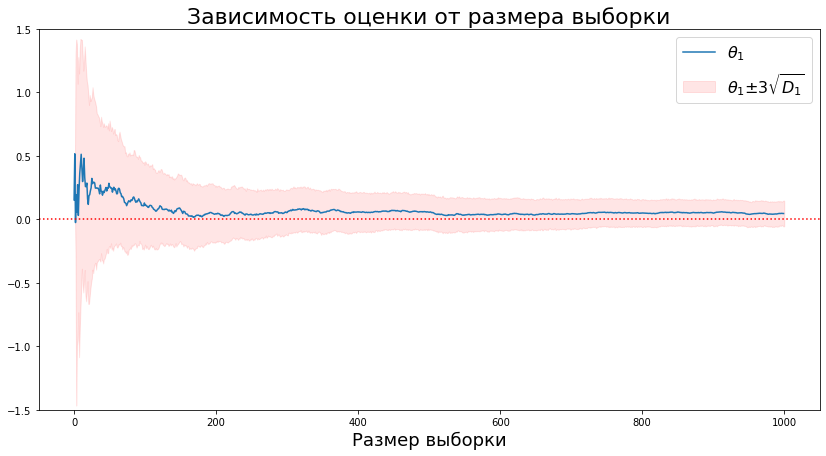

In [52]:
# визуализируем результат
show_task_one(all_estimations, all_variances, 0, (-1.5, 1.5), 0)

Построим график для второго параметра

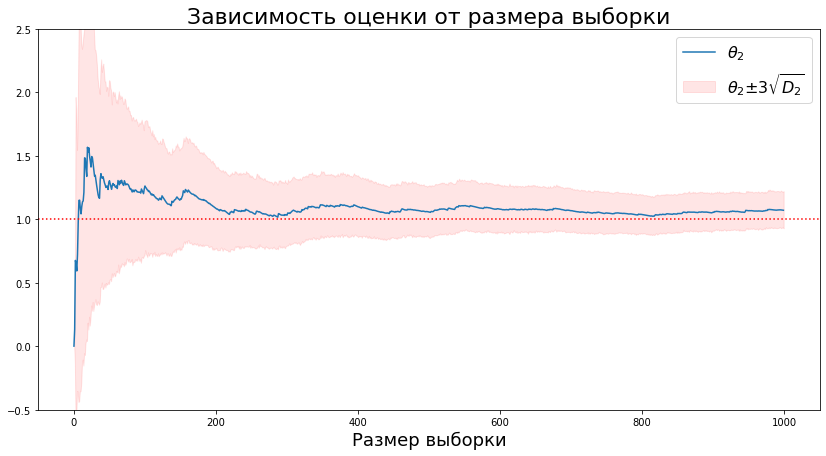

In [53]:
show_task_one(all_estimations, all_variances, 1, (-0.5, 2.5), 1)

## Вывод
Мы посчитали бутстрепную оценку дисперсии первого параметра в параметрическом бутстрепе. Видно, что истинное значение параметра всегда лежит в нашем "коридоре". Кроме того, коридор постепенно сужается с увеличением размера подвыборки. Вместе с тем, значение оценки параметра постоепенно приближается к истинному значению параметра.

Теперь аналогичным образом проведем эксперимент для непараметрического бутстрепа

In [87]:
mod = 'nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

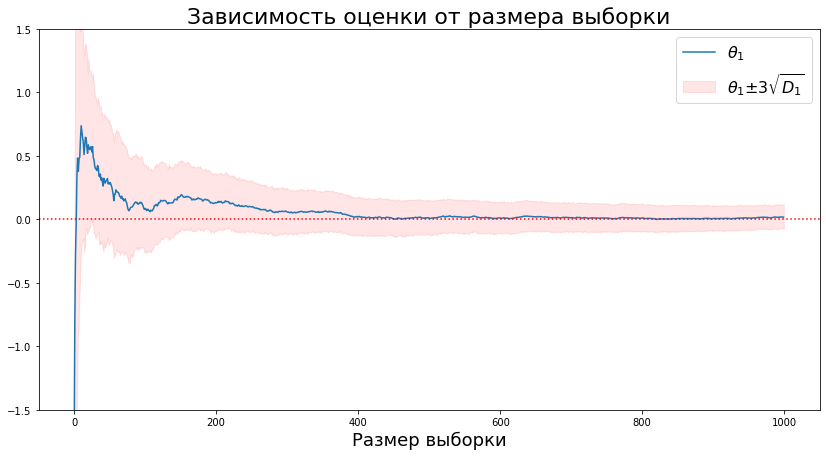

In [88]:
show_task_one(all_estimations, all_variances, 0, (-1.5, 1.5), 0)

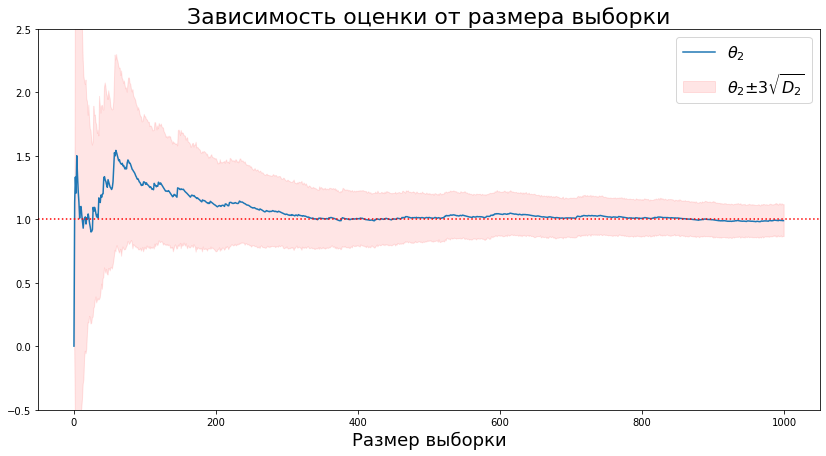

In [89]:
show_task_one(all_estimations, all_variances, 1, (-0.5, 2.5), 1)

## Вывод 
Аналогично предыдущему

Теперь аналогично для других истинных значений параметра

In [97]:
start_params = [5, 3]
mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators, 
                                          param_to_sps, mod, sps_args,
                                          start_params)

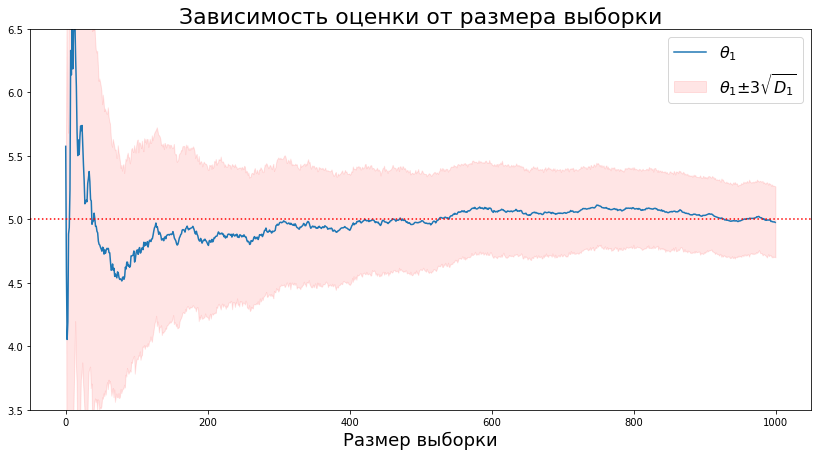

In [98]:
show_task_one(all_estimations, all_variances, 0, (5-1.5, 5+1.5), 5)

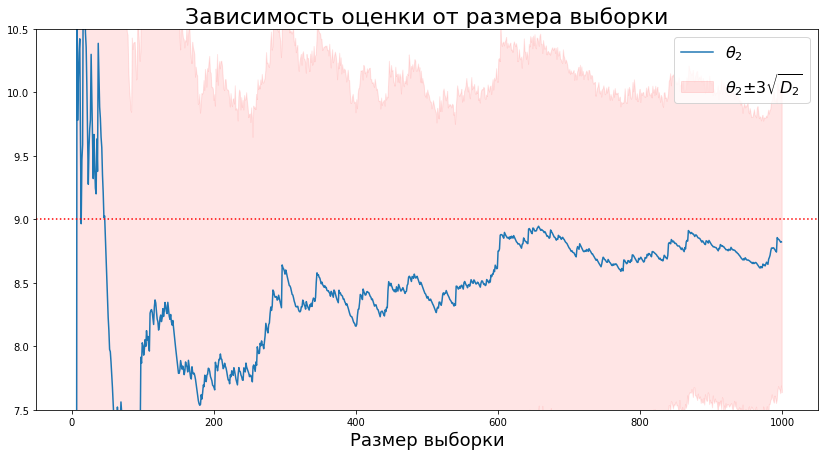

In [99]:
show_task_one(all_estimations, all_variances, 1, (9-3.5, 9+3.5), 9)

Непараметрический бутстреп

In [100]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

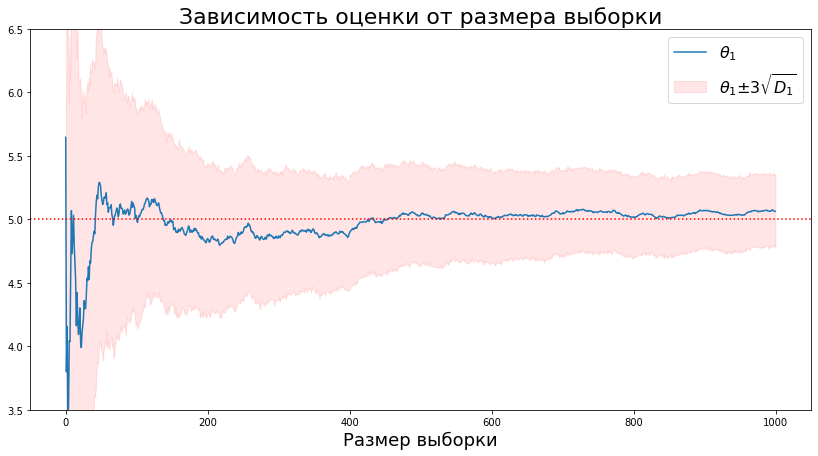

In [101]:
show_task_one(all_estimations, all_variances, 0, (5-1.5, 5+1.5), 5)

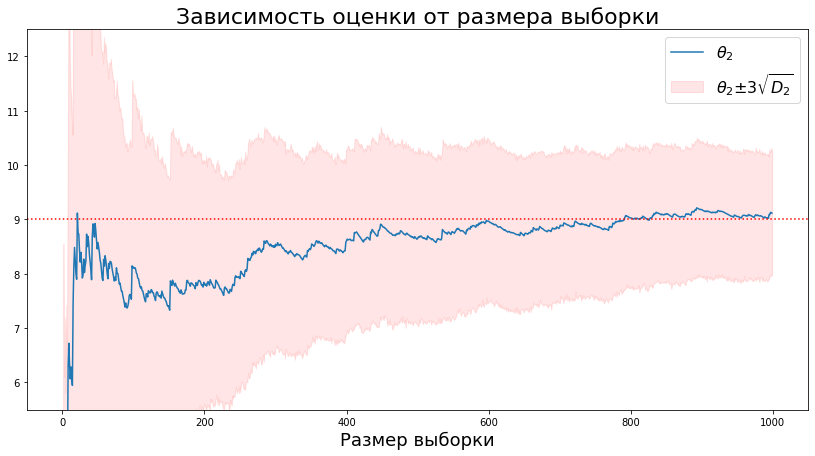

In [102]:
show_task_one(all_estimations, all_variances, 1, (9-3.5, 9+3.5), 9)

In [103]:
start_params = [10, 5]
mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

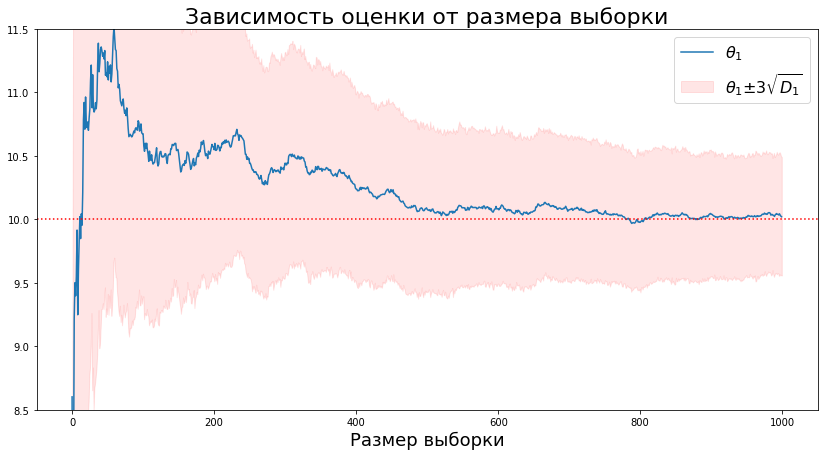

In [104]:
show_task_one(all_estimations, all_variances, 0, (10-1.5, 10+1.5), 10)

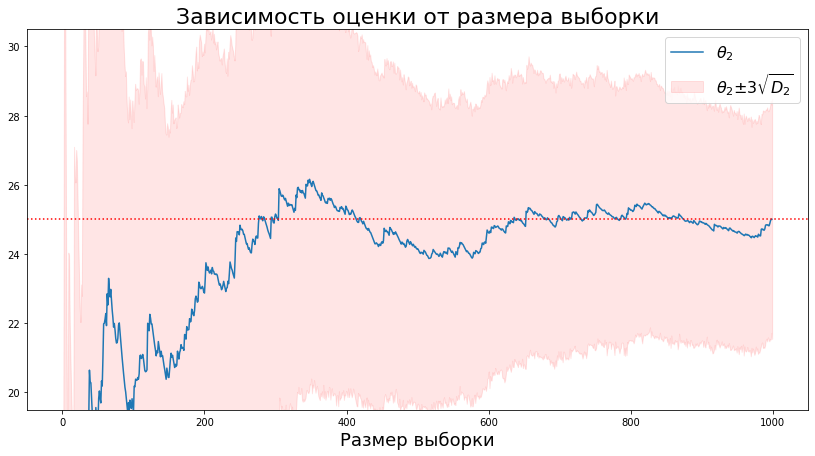

In [105]:
show_task_one(all_estimations, all_variances, 1, (25-5.5, 25+5.5), 25)

In [110]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args, 
                                          start_params)

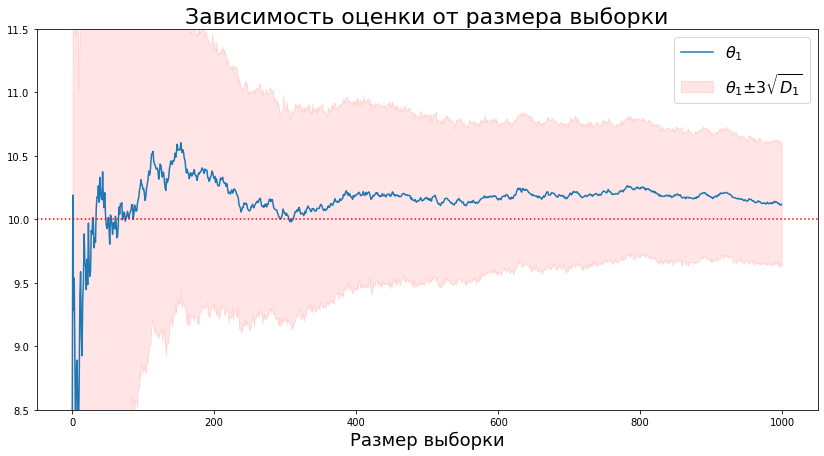

In [107]:
show_task_one(all_estimations, all_variances, 0, (10-1.5, 10+1.5), 10)

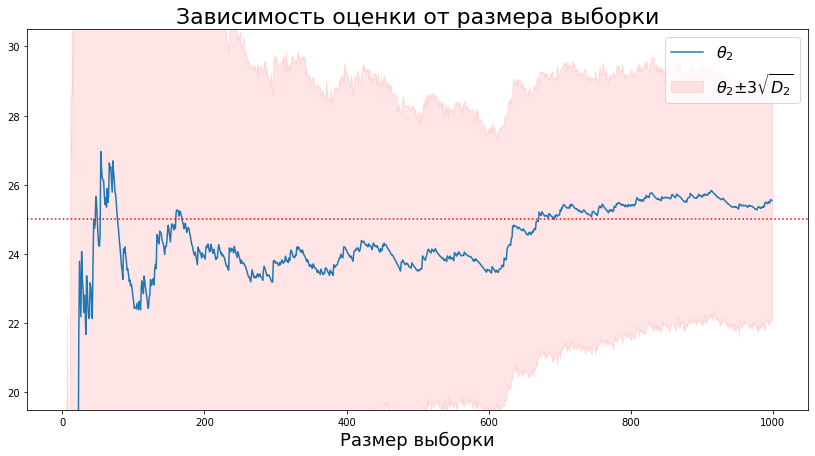

In [109]:
show_task_one(all_estimations, all_variances, 1, (25-5.5, 25+5.5), 25)

## Вывод
При увеличении истинных значений параметров может значительно увеличиться дисперсия

Аналогично для Гамма распределения 
$$X_i \sim Gamma(\theta_1, \theta_2) \Rightarrow {\theta}(x)=\left(\frac{\overline{X}}{S^{2}}, \overline{X}^{2}\right)$$

In [127]:
distribution = sps.gamma
start_params = [1.99]
estimators = [lambda x: np.mean(x, axis=-1) / np.var(x, axis=-1), 
              lambda x: np.mean(x, axis=-1)**2 / np.var(x, axis=-1)]
param_to_sps = [lambda vec: vec[1], 
                lambda vec: 1. / vec[0]]
sps_args = ['a', 'scale']

In [128]:
mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators, 
                                          param_to_sps, mod, sps_args,
                                          start_params)

Это на самом деле второй параметр:

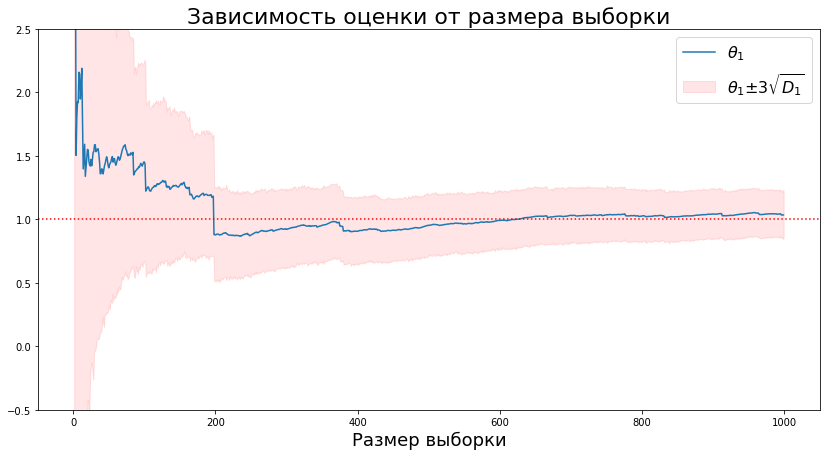

In [129]:
show_task_one(all_estimations, all_variances, 0, (-0.5, 2.5), xline=1)

А это первый

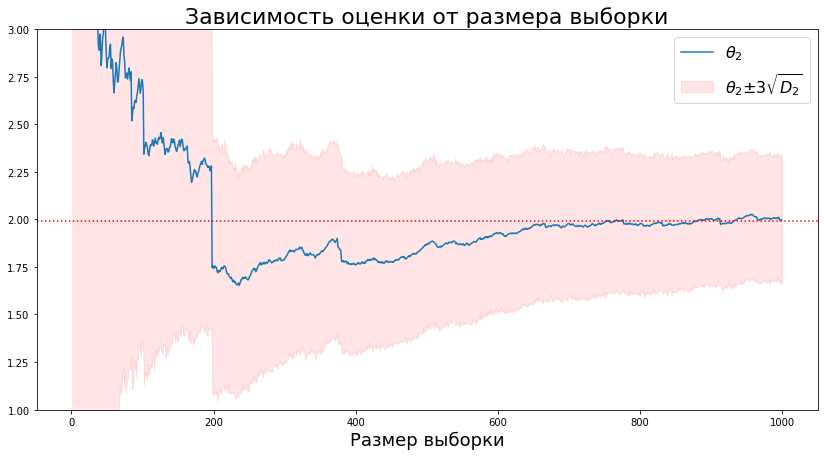

In [130]:
show_task_one(all_estimations, all_variances, 1, (1, 3), xline=1.99)

Аналогично для непараметрического

In [131]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

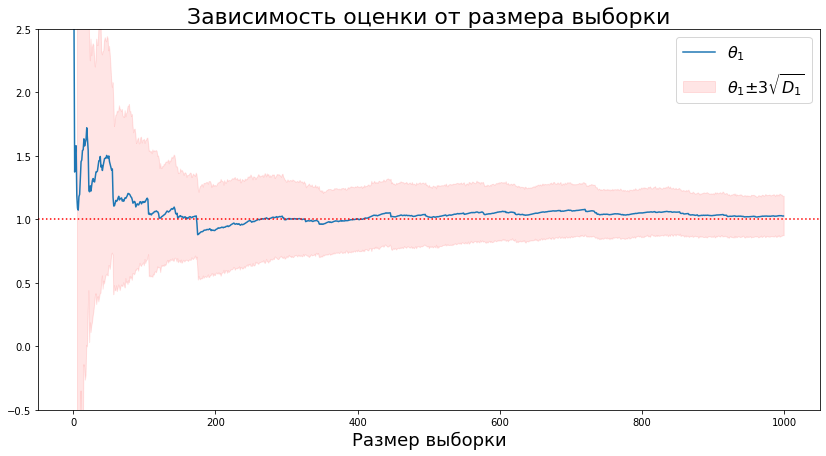

In [132]:
show_task_one(all_estimations, all_variances, 0, (-0.5, 2.5), xline=1)

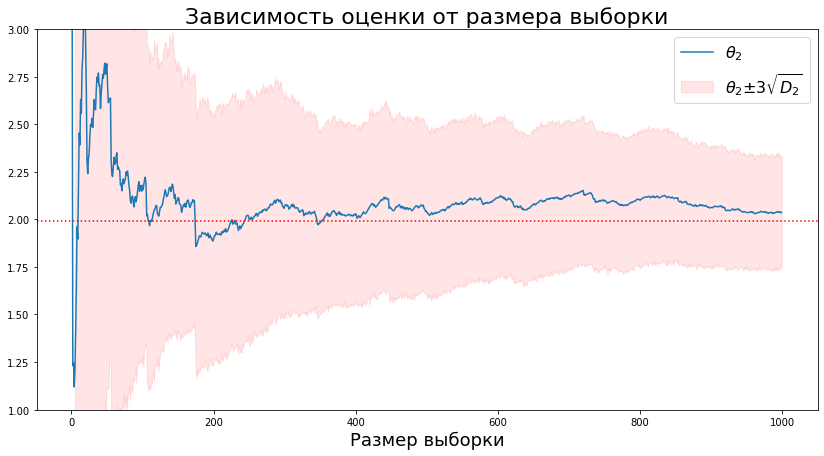

In [133]:
show_task_one(all_estimations, all_variances, 1, (1, 3), xline=1.99)

In [134]:
start_params = [6, 0, 3]
mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args, 
                                          start_params)

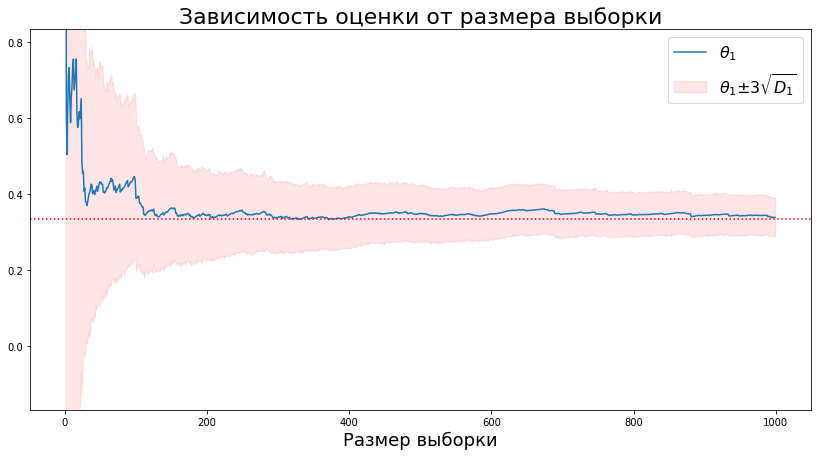

In [135]:
show_task_one(all_estimations, all_variances, 0, (1./3-0.5,1./3+0.5), xline=1./3)

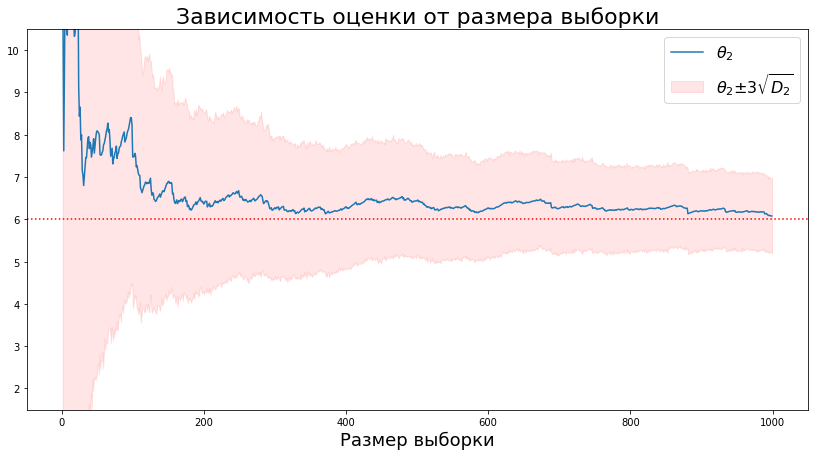

In [137]:
show_task_one(all_estimations, all_variances, 1, (6-4.5, 6+4.5), xline=6)

In [138]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators, 
                                          param_to_sps, mod, sps_args,
                                          start_params)

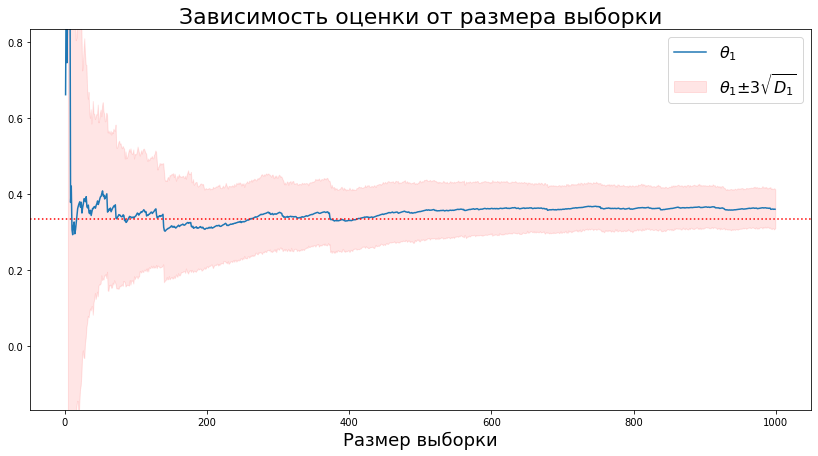

In [139]:
show_task_one(all_estimations, all_variances, 0, (1./3-0.5,1./3+0.5), xline=1./3)

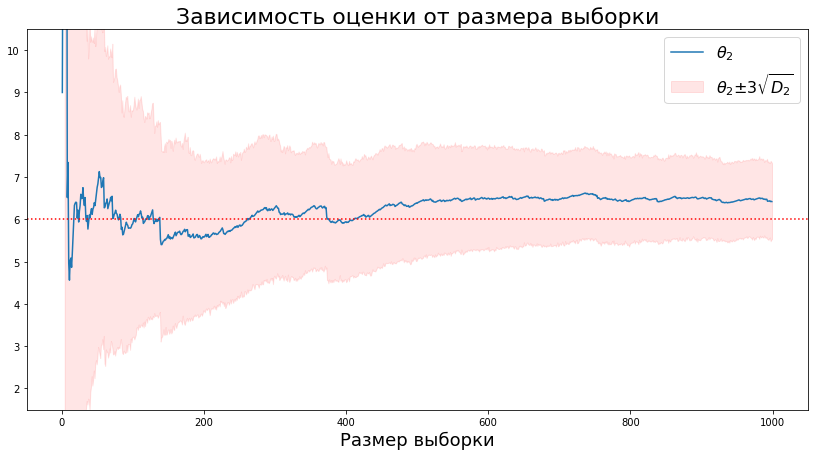

In [140]:
show_task_one(all_estimations, all_variances, 1, (6-4.5, 6+4.5), xline=6)

In [141]:
start_params = [10, 0, 0.5]
mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators, 
                                          param_to_sps, mod, sps_args,
                                          start_params)

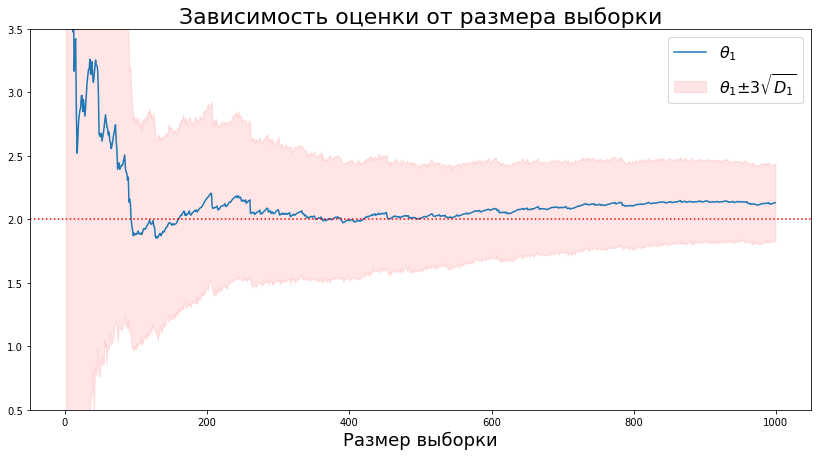

In [142]:
show_task_one(all_estimations, all_variances, 0, (2-1.5, 2+1.5), xline=2)

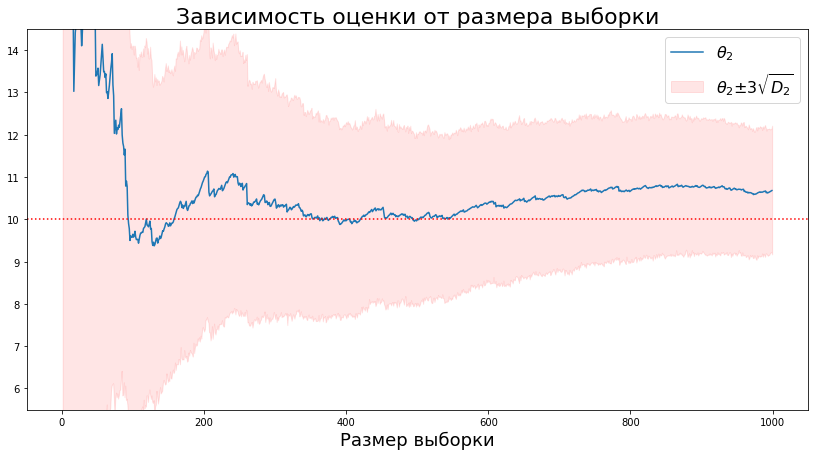

In [143]:
show_task_one(all_estimations, all_variances, 1, (10-4.5, 10+4.5), xline=10)

In [144]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

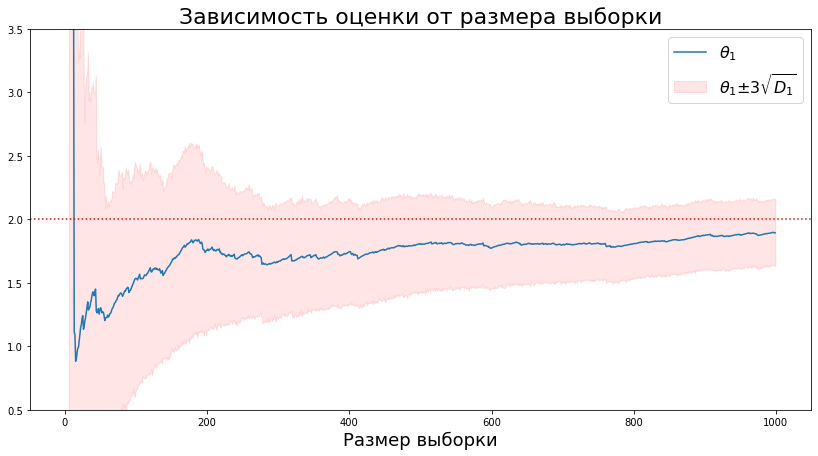

In [145]:
show_task_one(all_estimations, all_variances, 0, (2-1.5, 2+1.5), xline=2)

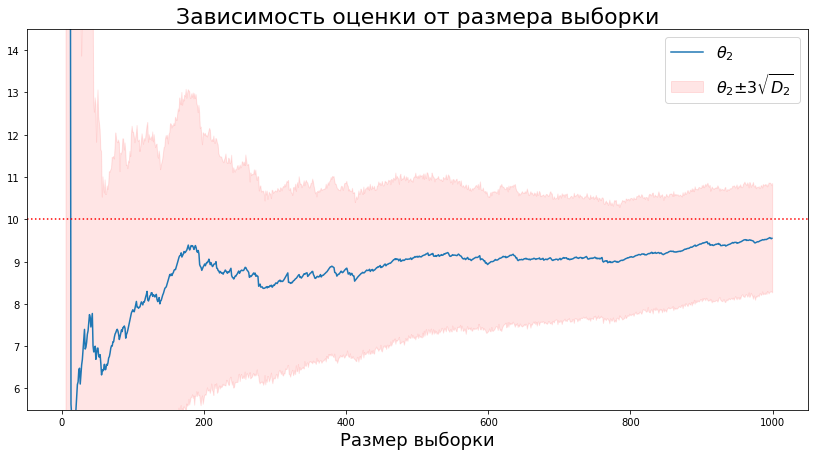

In [146]:
show_task_one(all_estimations, all_variances, 1, (10-4.5, 10+4.5), xline=10)

Равномерное распределение 
$$X_i \sim U(\theta_1, \theta_2) \Rightarrow {\theta}(x)=(\overline{X}-\sqrt{3 S^{2}}, \overline{X}+\sqrt{3 S^{2}})$$

In [7]:
distribution = sps.uniform
start_params = [0, 1]
estimators = [
    lambda x: np.mean(x, axis=-1) - np.sqrt(3 * np.var(x, axis=-1)), 
    lambda x: np.mean(x, axis=-1) + np.sqrt(3 * np.var(x, axis=-1))
]
param_to_sps = [lambda vec: vec[0], 
                lambda vec: vec[1] - vec[0]]
sps_args = ['loc', 'scale']

mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

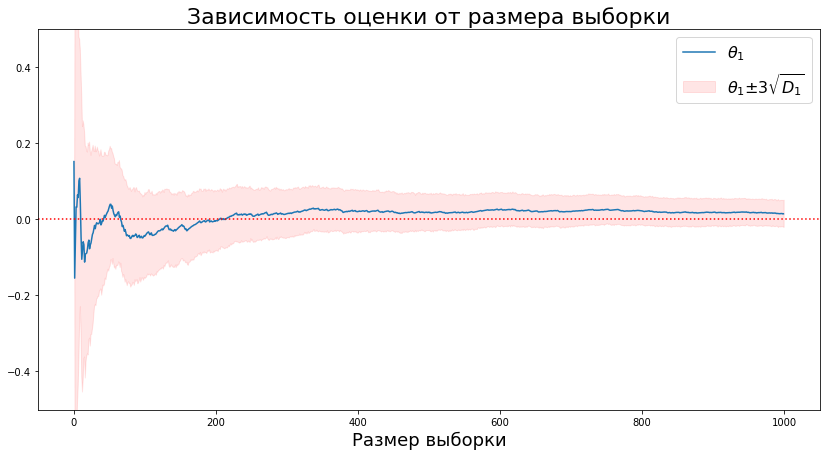

In [8]:
show_task_one(all_estimations, all_variances, 0, (-0.5, 0.5), xline=0)

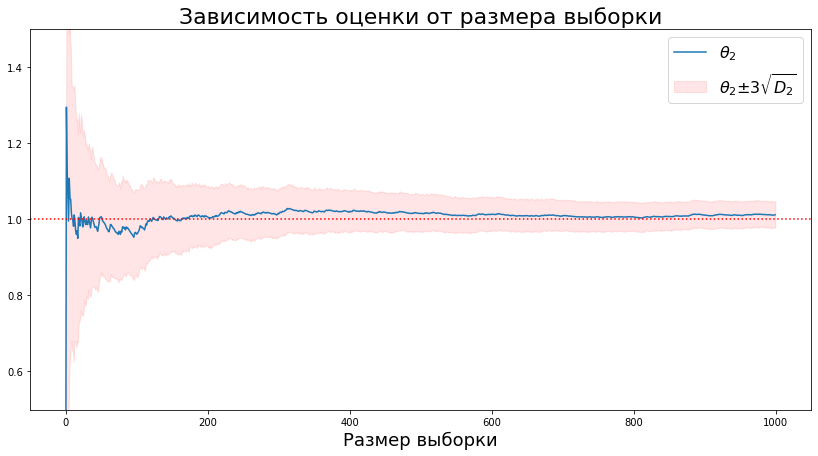

In [9]:
show_task_one(all_estimations, all_variances, 1, (0.5, 1.5), xline=1)

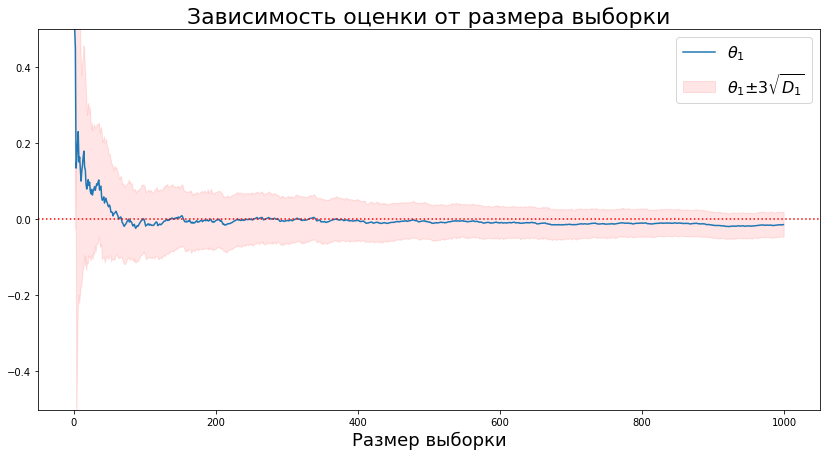

In [10]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators, 
                                          param_to_sps, mod, sps_args, 
                                          start_params)
show_task_one(all_estimations, all_variances, 0, (-0.5, 0.5), xline=0)

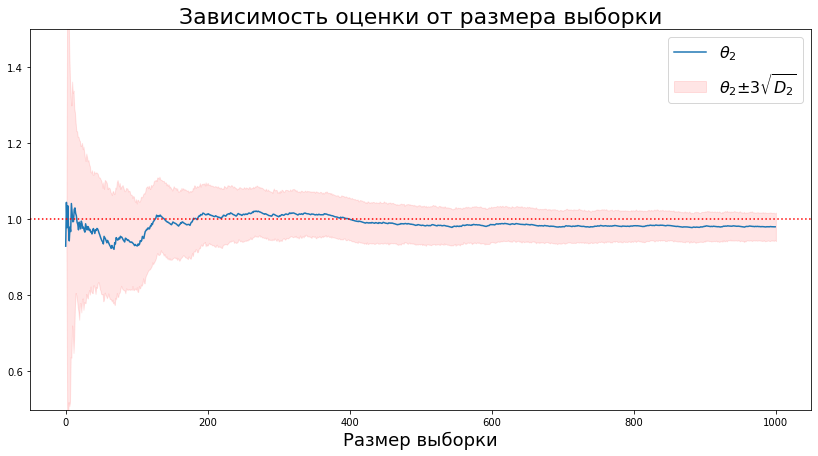

In [11]:
show_task_one(all_estimations, all_variances, 1, (1-0.5, 1.5), xline=1)

Попробуем для распределения U[5, 8]

In [12]:
start_params = [5, 3]
mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args, 
                                          start_params)

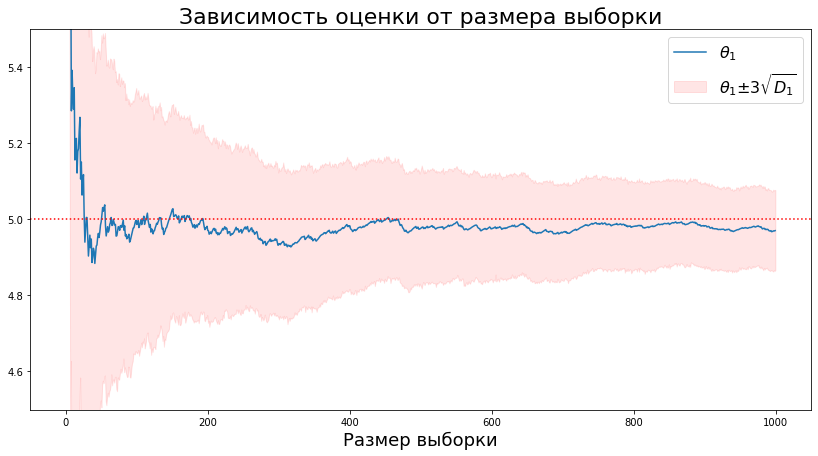

In [13]:
show_task_one(all_estimations, all_variances, 0, (5-0.5, 5+0.5), xline=5)

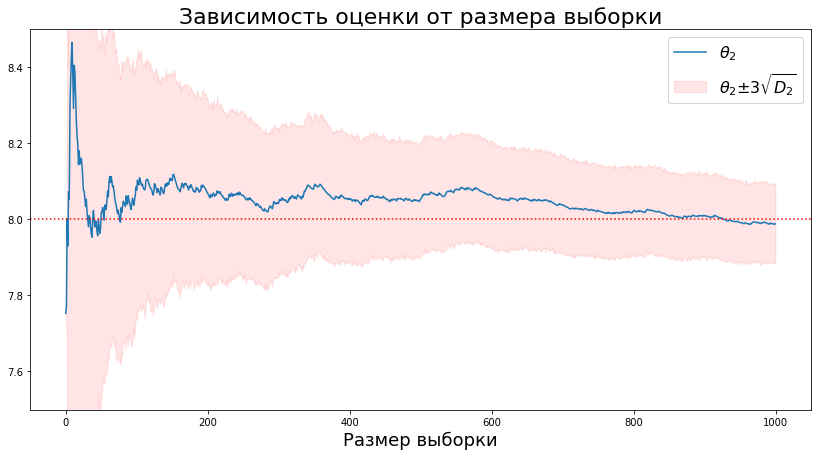

In [15]:
show_task_one(all_estimations, all_variances, 1, (8-0.5, 8+0.5), xline=8)

In [16]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

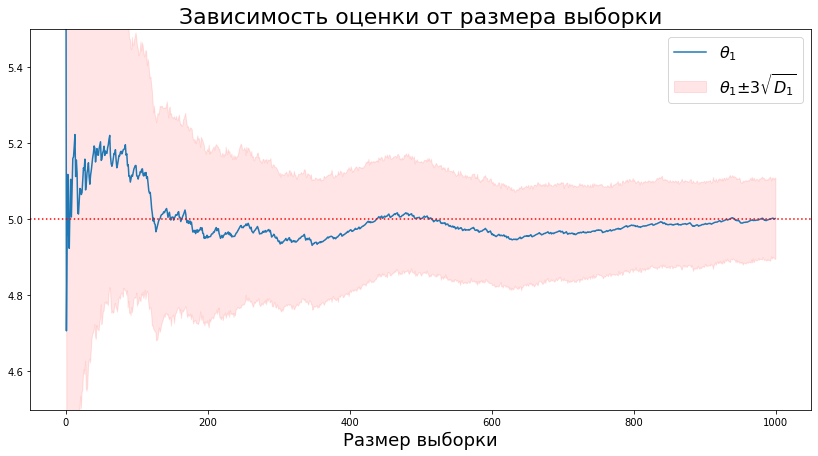

In [17]:
show_task_one(all_estimations, all_variances, 0, (5-0.5, 5+0.5), xline=5)

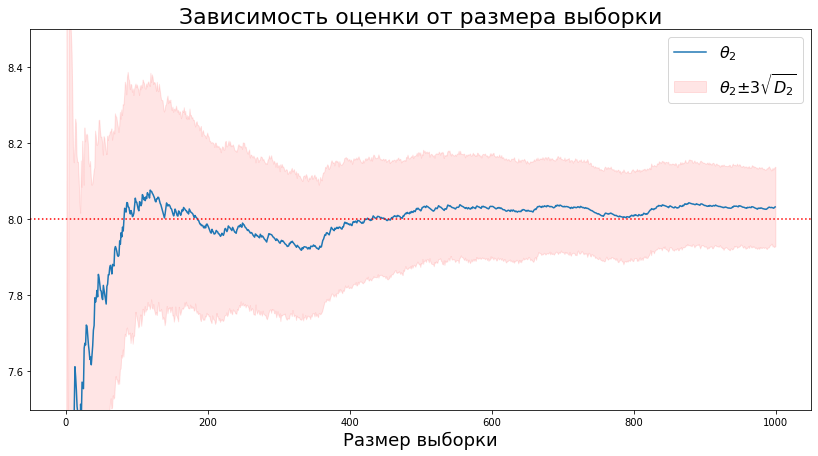

In [18]:
show_task_one(all_estimations, all_variances, 1, (8-0.5, 8+0.5), xline=8)

$$U[15,20]$$

In [19]:
start_params = [15, 5]
mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

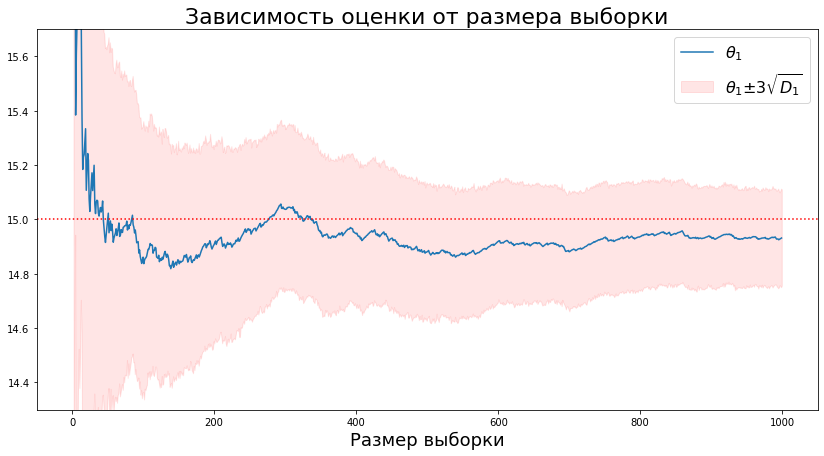

In [20]:
show_task_one(all_estimations, all_variances, 0, (15-0.7, 15+0.7), xline=15)

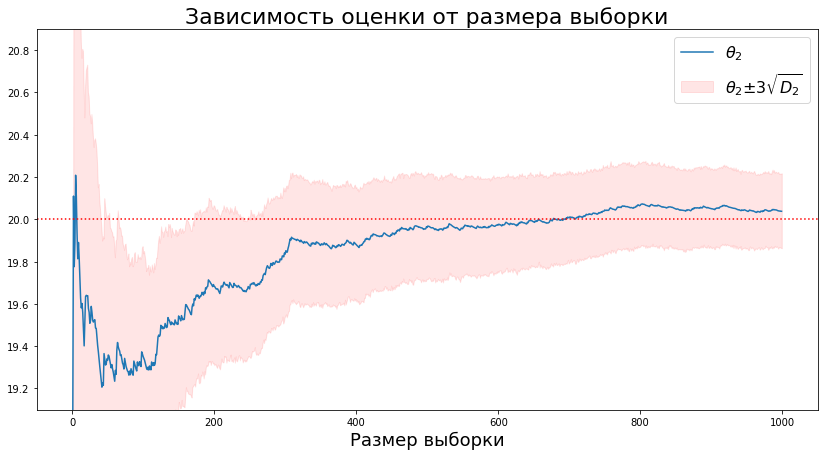

In [22]:
show_task_one(all_estimations, all_variances, 1, (20-0.9, 20+0.9), xline=20)

In [23]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args, 
                                          start_params)

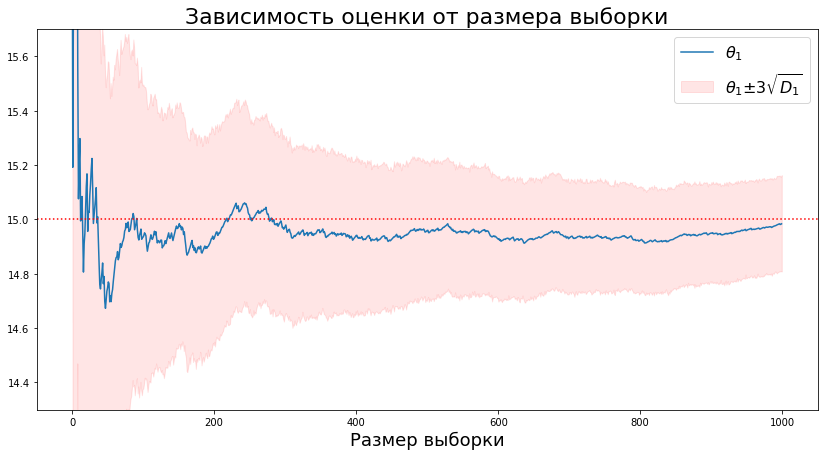

In [25]:
show_task_one(all_estimations, all_variances, 0, (15-0.7, 15+0.7), xline=15)

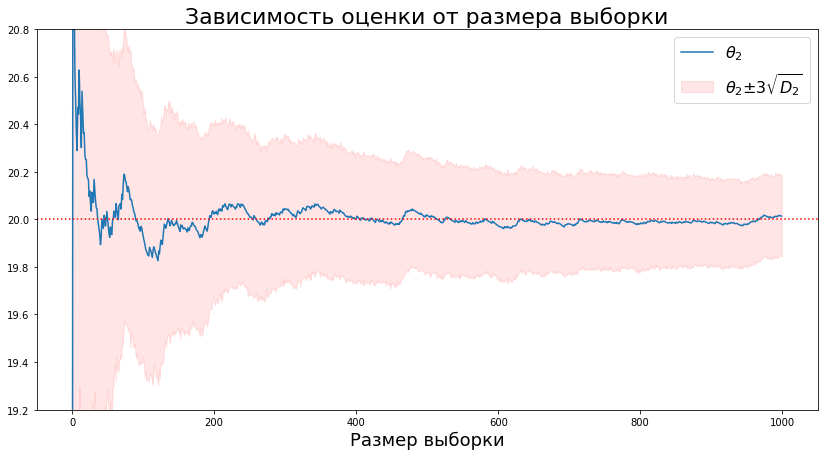

In [26]:
show_task_one(all_estimations, all_variances, 1, (20-0.8, 20+0.8), xline=20)

$$X_i \sim Pois(\theta) \Rightarrow {\theta}(X)=\overline{X}$$

In [27]:
distribution = sps.poisson
start_params = [0.6]
estimators = [lambda x: np.mean(x, axis=-1)]
param_to_sps = [lambda vec: vec[0]]
sps_args = ['mu']

mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)

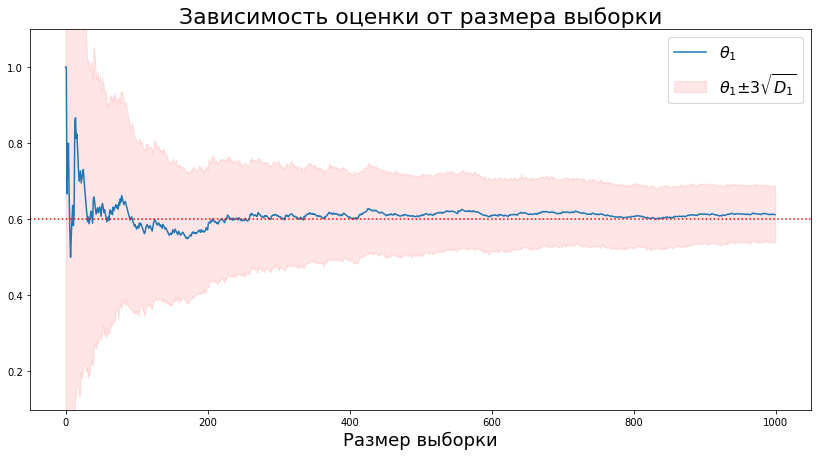

In [28]:
show_task_one(all_estimations, all_variances, 0, (0.6-0.5, 0.6+0.5), xline=0.6)

In [31]:
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args, 
                                          start_params)

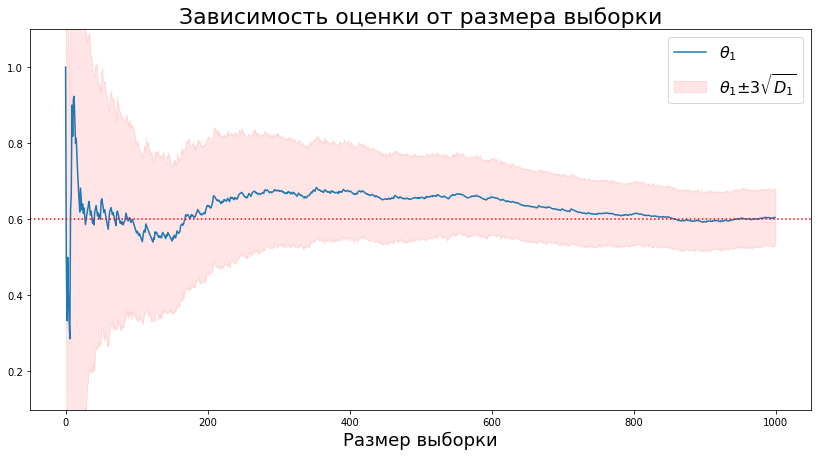

In [32]:
show_task_one(all_estimations, all_variances, 0, (0.6-0.5, 0.6+0.5), xline=0.6)

Попробуем для 
$$Pois(3)$$

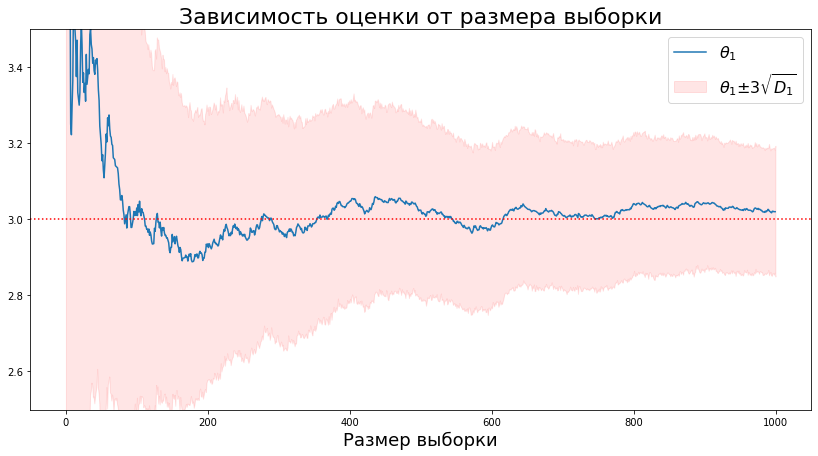

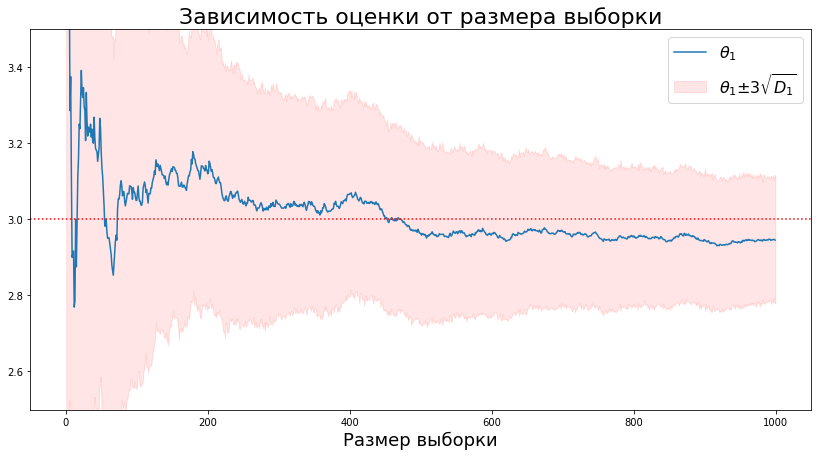

In [34]:
start_params = [3]
mod='parametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args,
                                          start_params)
show_task_one(all_estimations, all_variances, 0, (3-0.5, 3+0.5), xline=3)
mod='nonparametric'
all_estimations, all_variances = task_one(distribution, estimators,
                                          param_to_sps, mod, sps_args, 
                                          start_params)
show_task_one(all_estimations, all_variances, 0, (3-0.5, 3+0.5), xline=3)

$$X_i \sim Bin(\theta_1, \theta_2) \Rightarrow {\theta}(X)=\left(\frac{\overline{X}^{2}}{\overline{X}-S^{2}}, \frac{\overline{X}-S^{2}}{\overline{X}}\right)$$

## Warning
Далее, из-за использования циклов при рисовании графиков, в .pdf версии некоторые графики отображаются плохо (накладываются). В .ipynb версии отображается нормально.

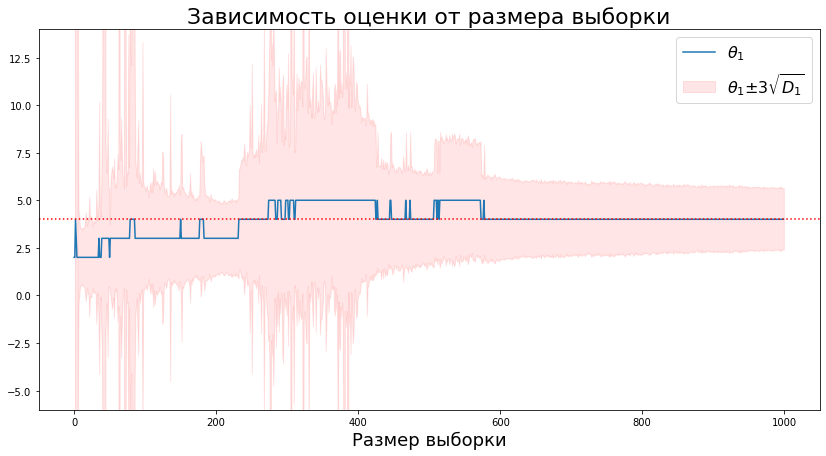

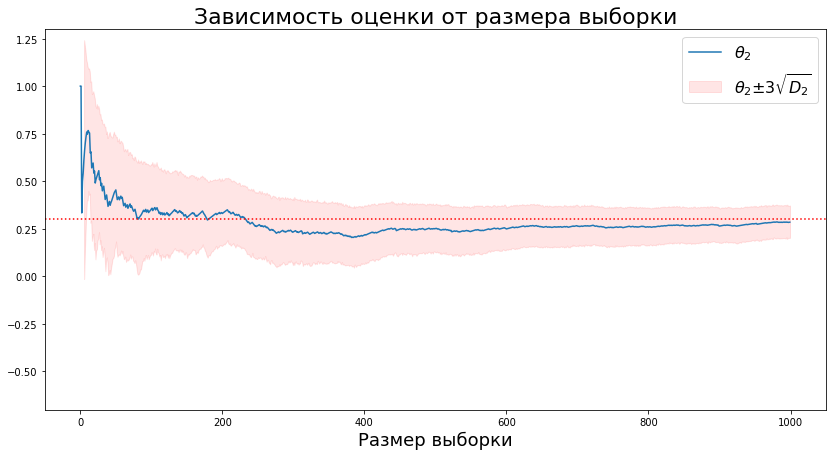

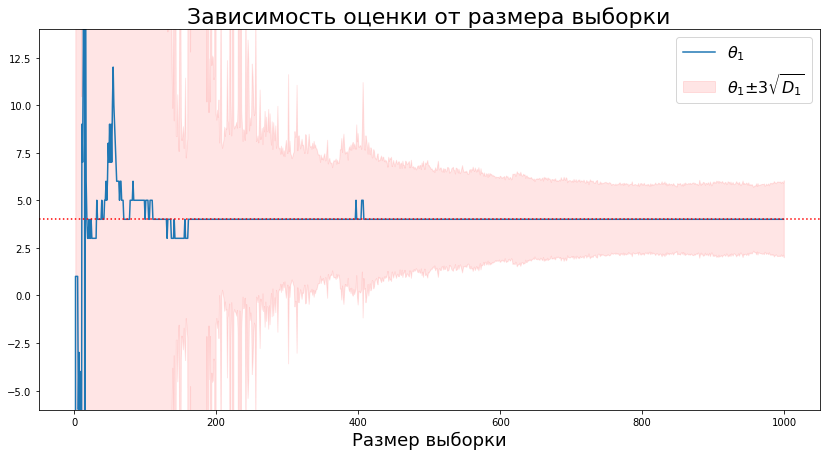

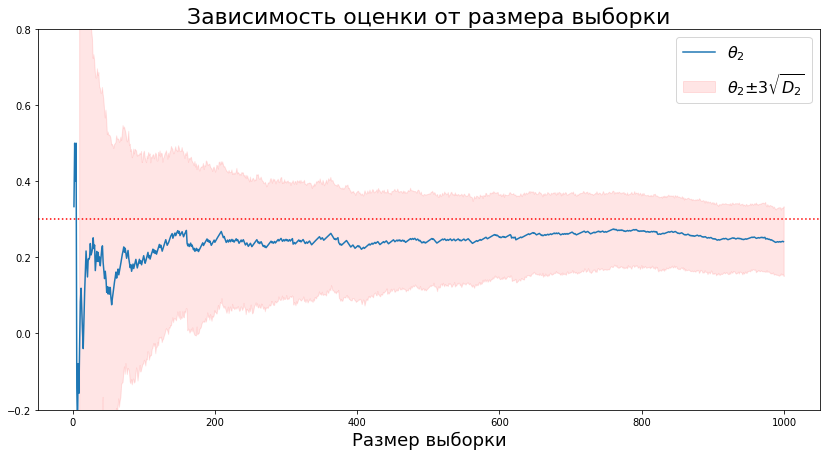

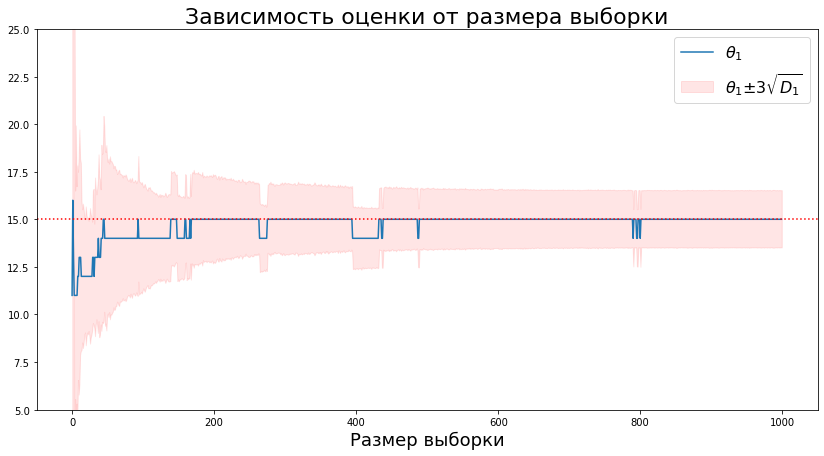

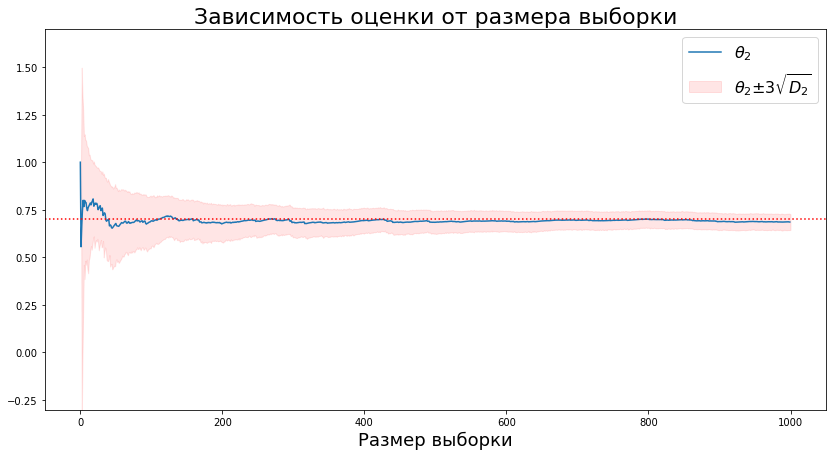

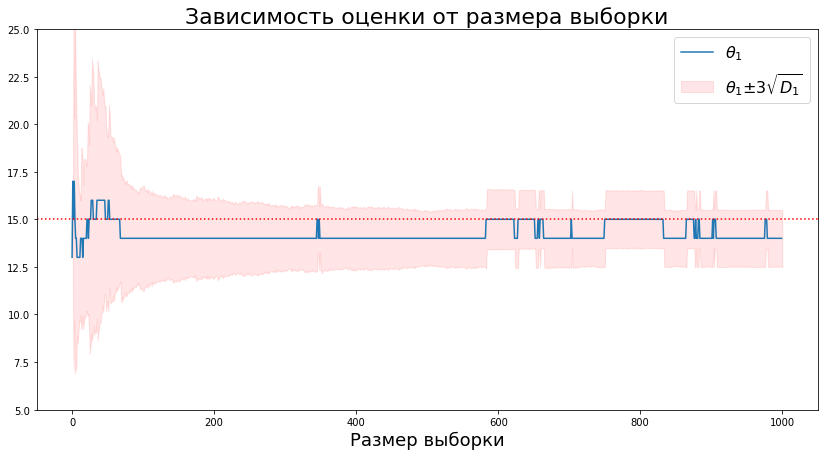

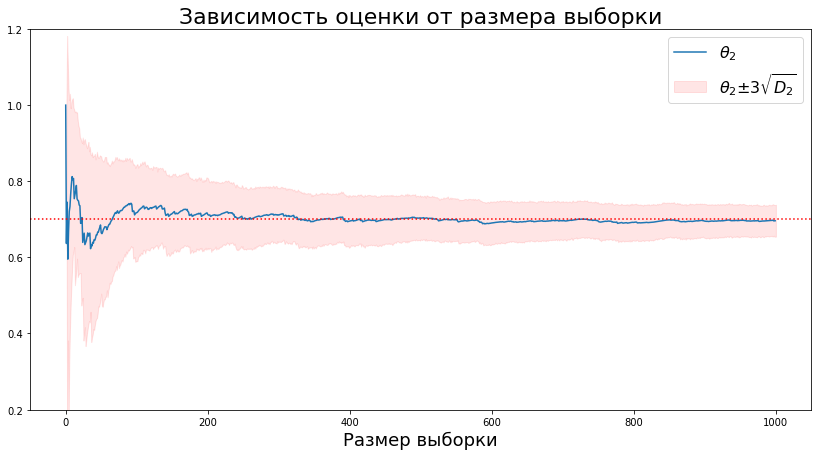

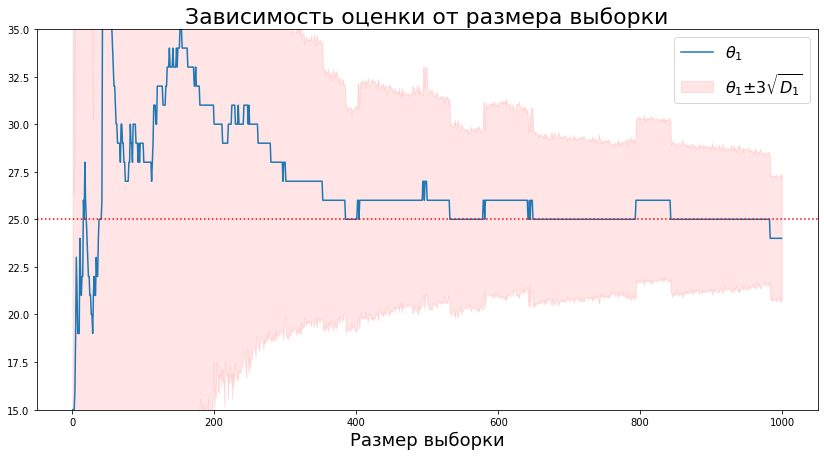

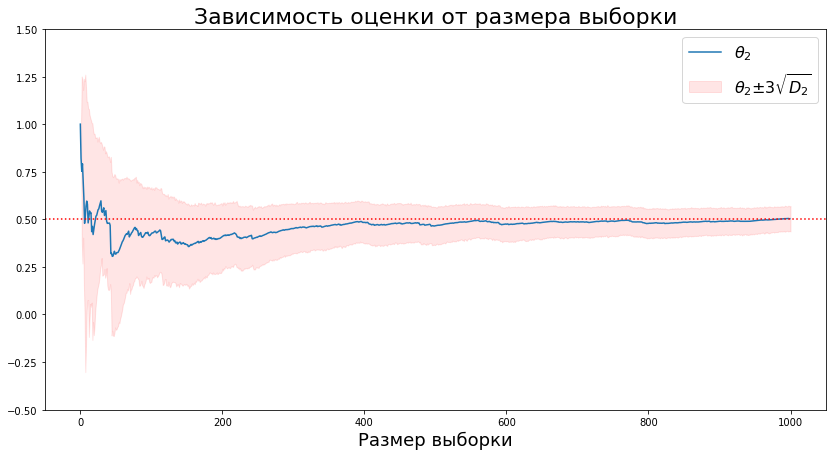

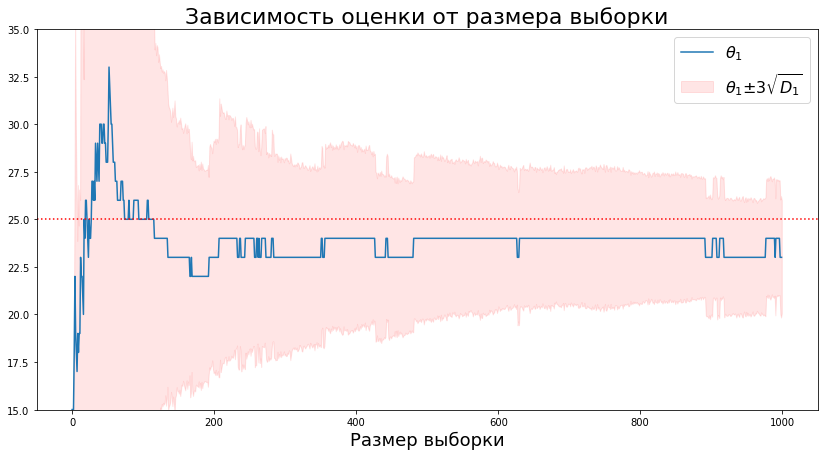

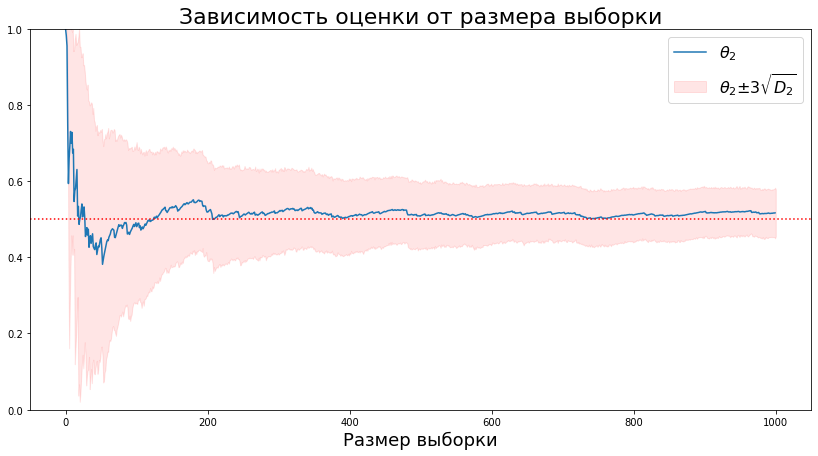

In [50]:
distribution = sps.binom
# все параметры, для которых будем решать задачу
all_start_params = [[4, 0.3], [15, 0.7], [25, 0.5]]
estimators = [
    lambda x: (np.mean(x, axis=-1)**2 / 
               (np.mean(x, axis=-1) - np.var(x, axis=-1))).astype(int),
    lambda x: (np.mean(x, axis=-1) - np.var(x, axis=-1)) / np.mean(x, axis=-1)
]

param_to_sps = [
    lambda vec: vec[0],
    lambda vec: vec[1]
]
sps_args = ['n', 'p']

for start_params in all_start_params:
    # theta_1 и theta_2 
    n_param, p_param = start_params
    # для зафиксированных параметров запускаем параметрический бутстреп
    mod='parametric'
    all_estimations, all_variances = task_one(distribution, estimators, 
                                              param_to_sps, mod, sps_args,
                                              start_params)
    show_task_one(all_estimations, all_variances, 0, 
                  (n_param-10, n_param+10), xline=n_param)
    show_task_one(all_estimations, all_variances, 1, 
                  (p_param-1, p_param+1), xline=p_param)
    # для зафиксированных параметров запускаем _не_параметрический бутстреп
    mod='nonparametric'
    all_estimations, all_variances = task_one(distribution, estimators,
                                              param_to_sps, mod, sps_args, 
                                              start_params)
    show_task_one(all_estimations, all_variances, 0, 
                  (n_param-10, n_param+10), xline=n_param)
    show_task_one(all_estimations, all_variances, 1,
                  (p_param-0.5, p_param+0.5), xline=p_param)

$$X_i \sim Geom(\theta) \Rightarrow {\theta}(X)=\frac{1}{\overline{X}}$$

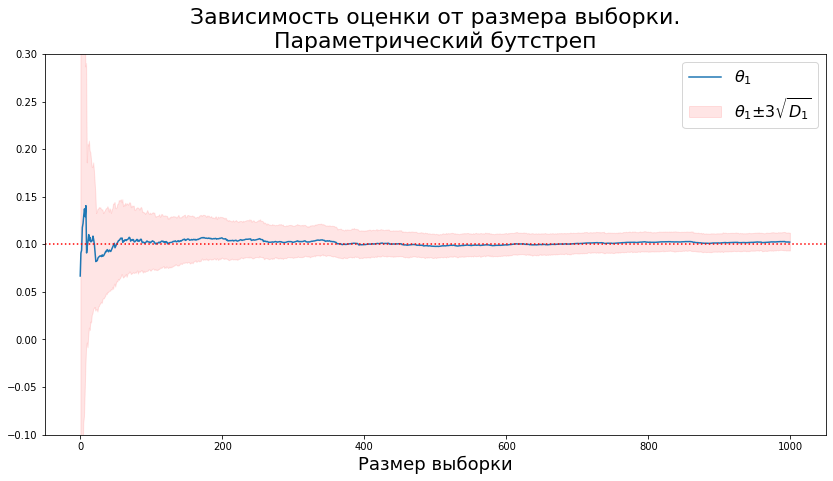

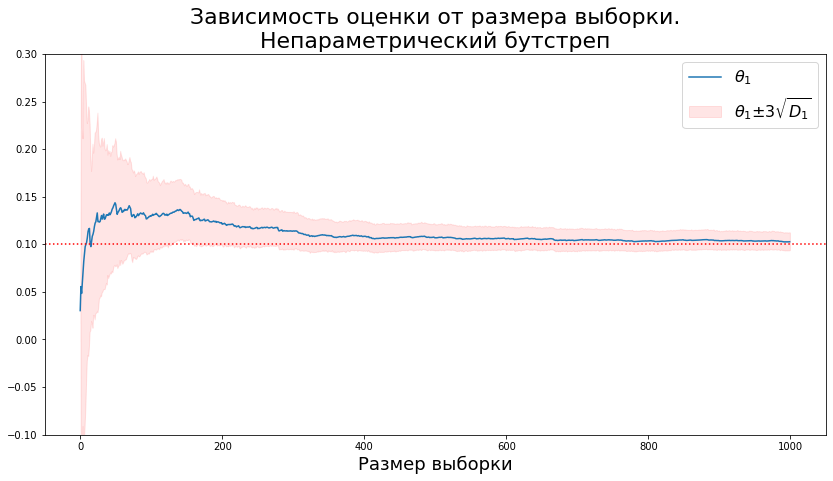

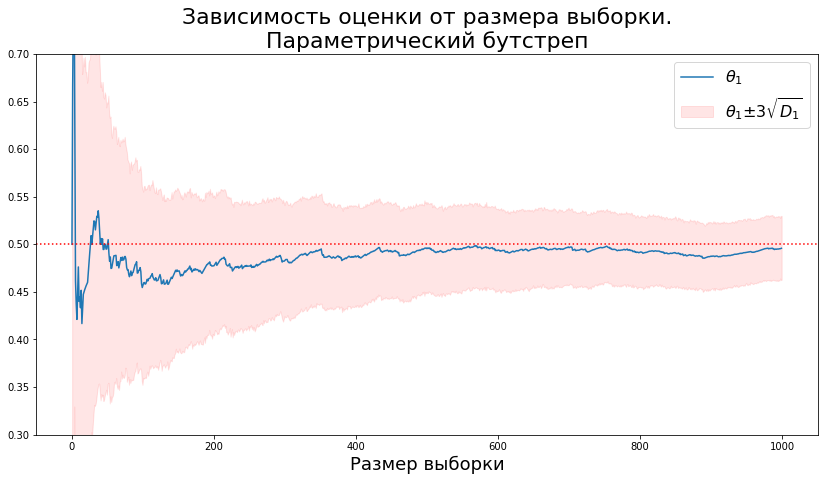

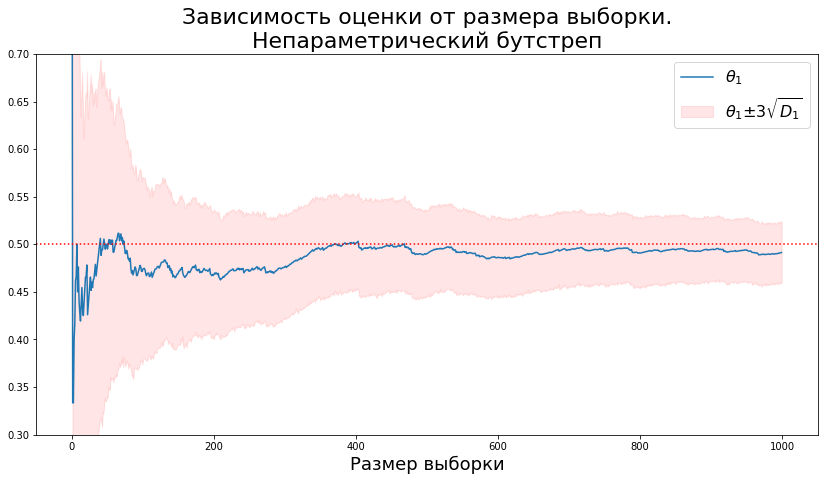

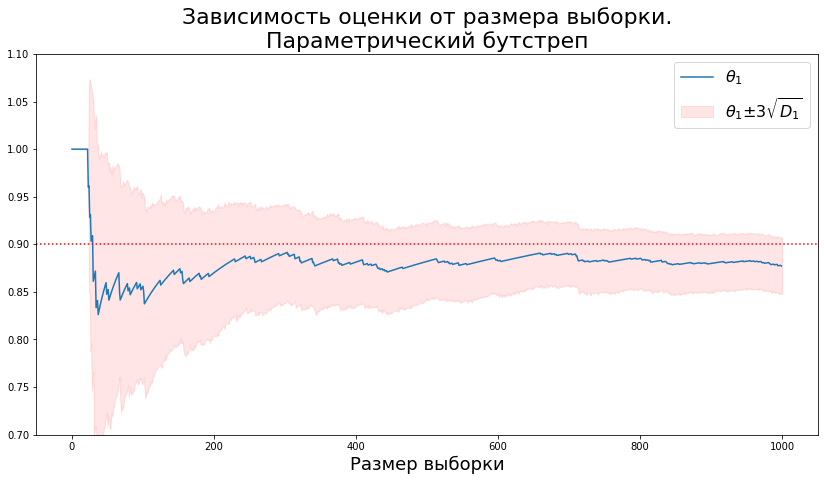

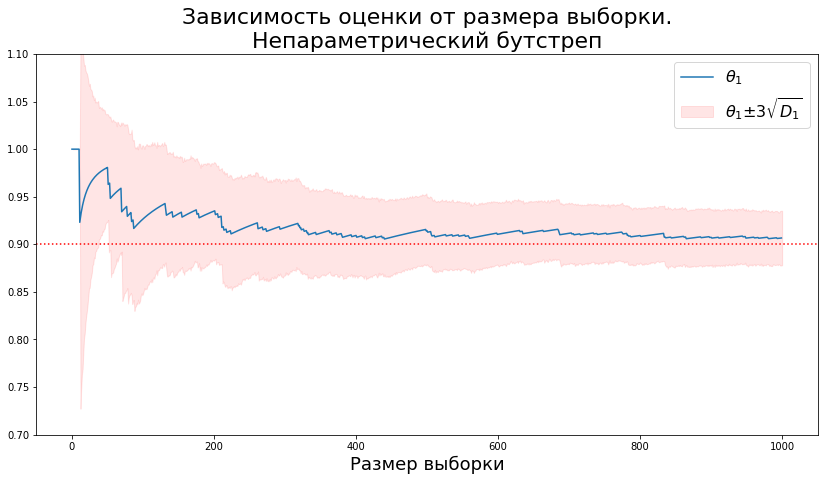

In [59]:
distribution = sps.geom
all_start_params = [[0.1], [0.5], [0.9]]
estimators = [
    lambda x: 1. / np.mean(x, axis=-1)
]
param_to_sps = [
    lambda vec: vec[0]
]
sps_args = ['p']

for start_params in all_start_params:
    p = start_params[0]
    mod='parametric'
    all_estimations, all_variances = task_one(distribution, estimators,
                                              param_to_sps, mod, sps_args,
                                              start_params)
    show_task_one(all_estimations, all_variances, 0, 
                  (p-0.2, p+0.2), xline=p, mod=mod)
    mod='nonparametric'
    all_estimations, all_variances = task_one(distribution, estimators,
                                              param_to_sps, mod, sps_args, 
                                              start_params)
    show_task_one(all_estimations, all_variances, 0,
                  (p-0.2, p+0.2), xline=p, mod=mod)

$$X_i \sim Beta(\theta_1, \theta_2) \Rightarrow {\theta}(X)=\left( \overline{X}\left[ \frac{\overline{X}\left(1-\overline{X}\right)}{S^2}-1 \right], \left(1-\overline{X}\right)\left[ \frac{\overline{X}\left(1-\overline{X}\right)}{S^2}-1 \right] \right)$$

Покажем для распределений $$Beta(2.31, 0.627), \ Beta(5, 3), \ Beta(10, 0.1)$$

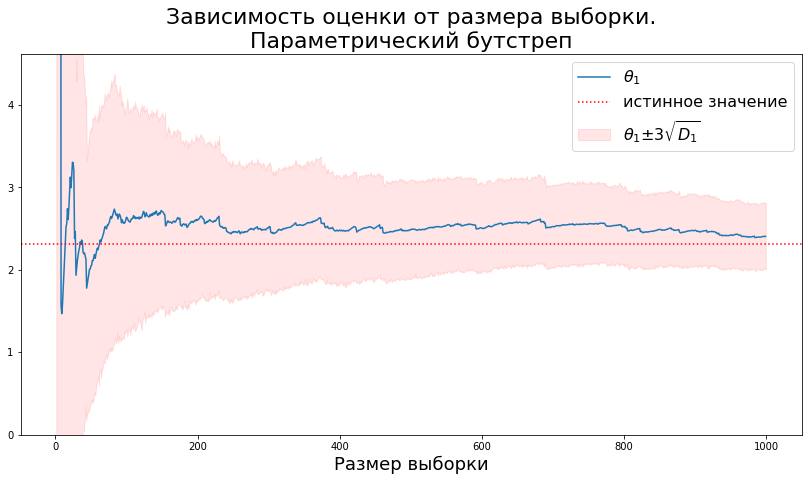

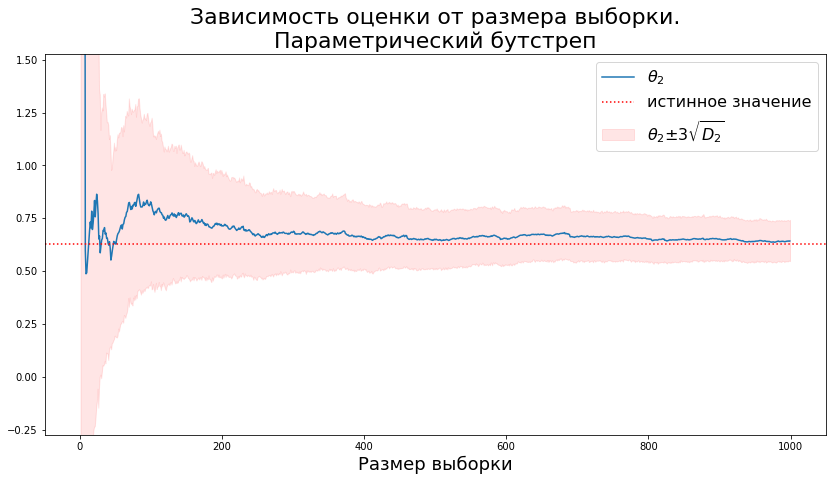

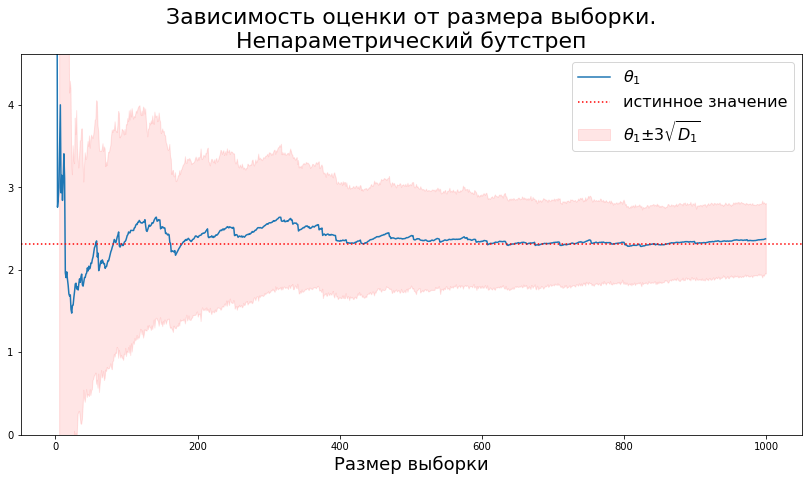

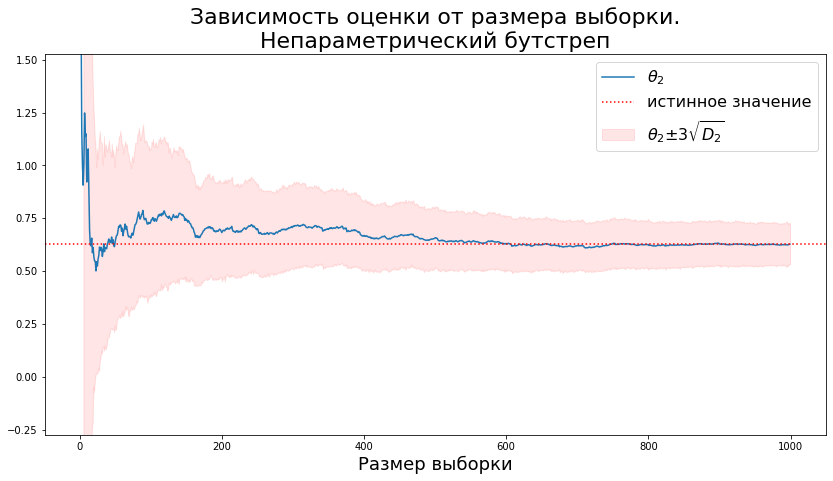

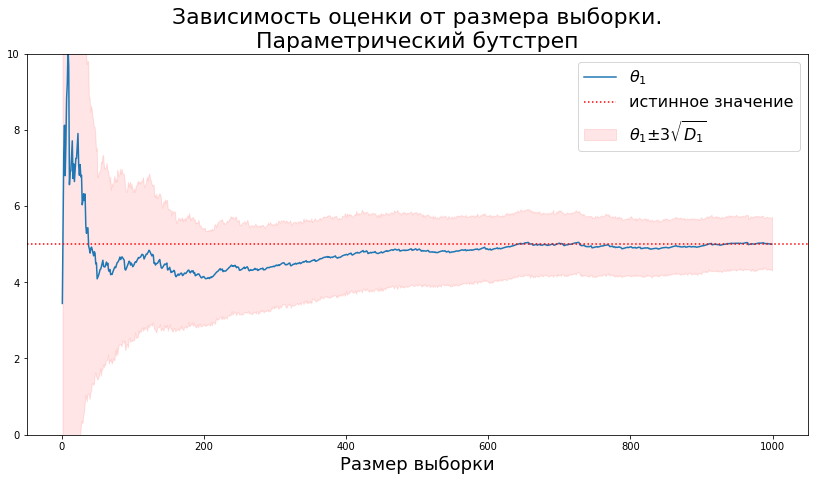

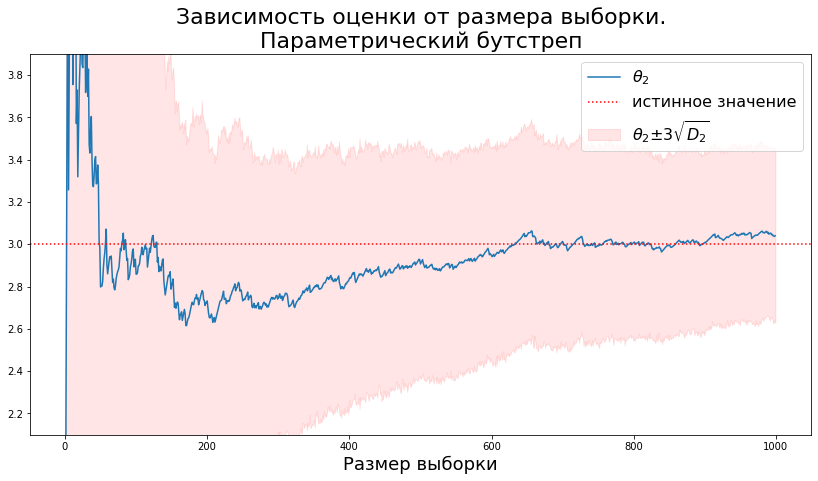

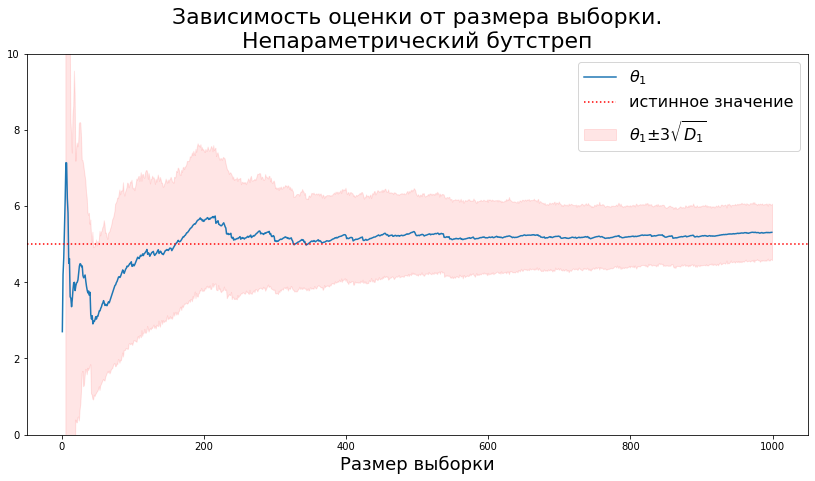

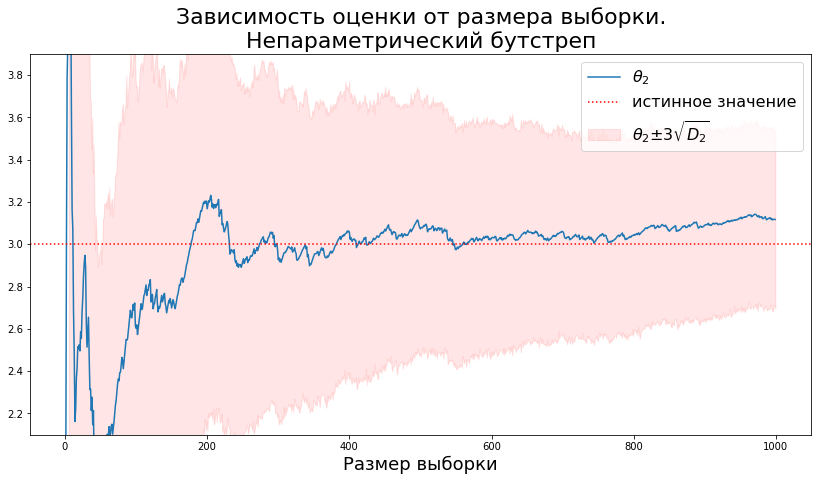

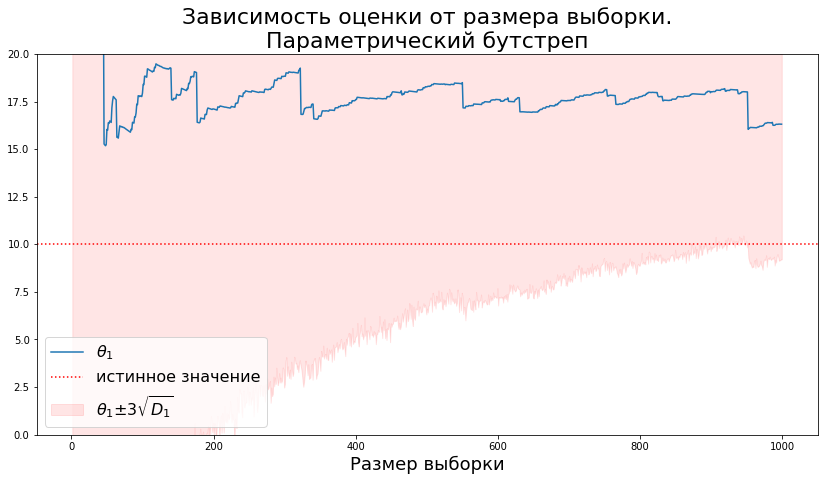

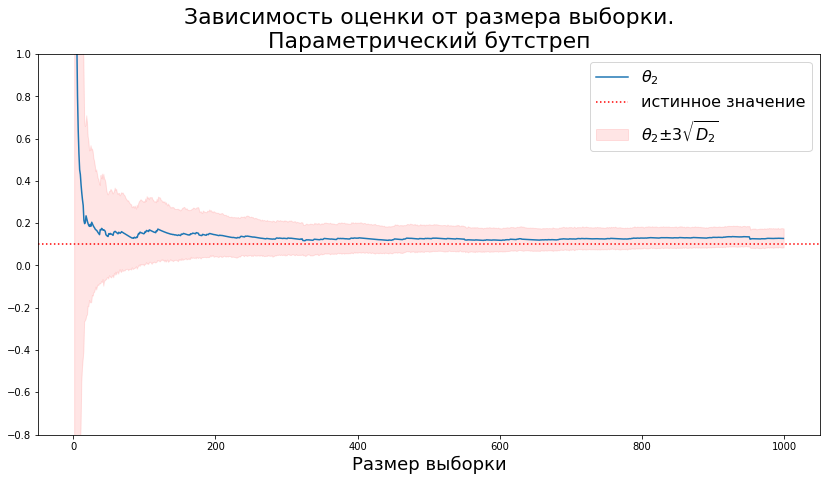

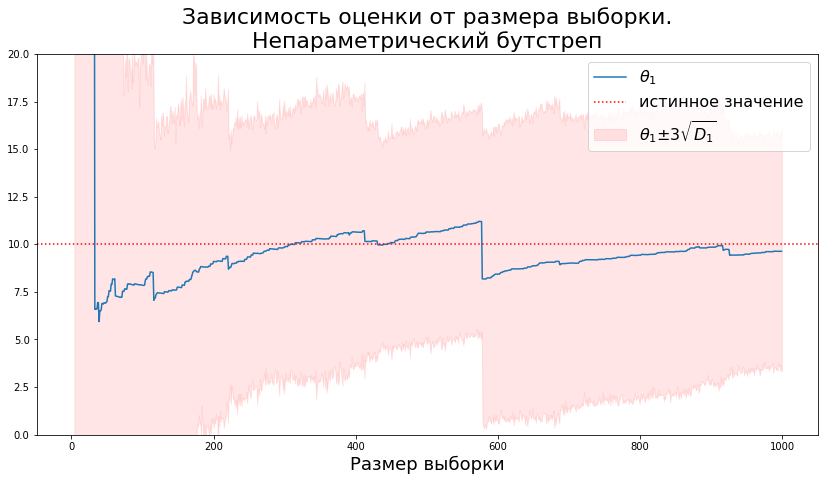

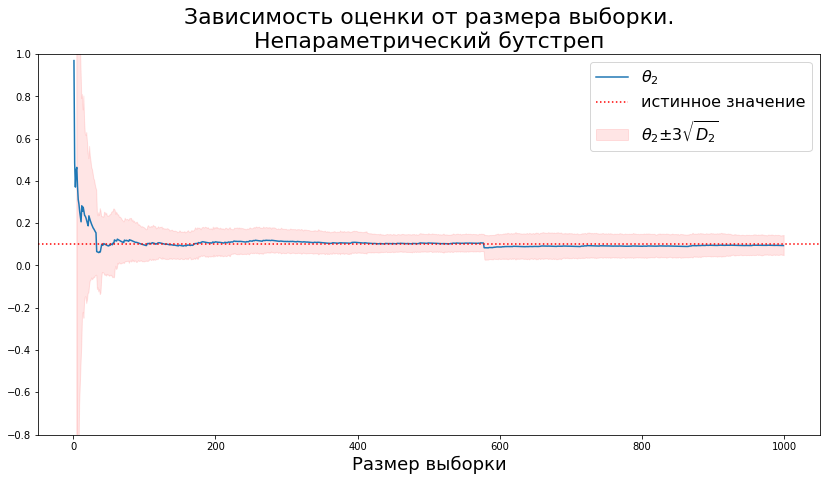

In [66]:
distribution = sps.beta
all_start_params = [[2.31, 0.627], [5, 3], [10, 0.1]]
rhs = lambda x: np.mean(x, axis=-1) * \
(1. - np.mean(x, axis=-1)) / np.var(x, axis=-1) - 1.

estimators = [
    lambda x: np.mean(x, axis=-1) * rhs(x),
    lambda x: (1. - np.mean(x, axis=-1)) * rhs(x)
]
param_to_sps = [
    lambda vec: vec[0],
    lambda vec: vec[1]
]
sps_args = ['a', 'b']

for start_params in all_start_params:
    a, b = start_params
    mod='parametric'
    all_estimations, all_variances = task_one(distribution, estimators,
                                              param_to_sps, mod, sps_args,
                                              start_params)
    show_task_one(all_estimations, all_variances, 0, 
                  (a-a, a+a), xline=a, mod=mod)
    show_task_one(all_estimations, all_variances, 1,
                  (b-0.9, b+0.9), xline=b, mod=mod)
    mod='nonparametric'
    all_estimations, all_variances = task_one(distribution, estimators, 
                                              param_to_sps, mod, sps_args,
                                              start_params)
    show_task_one(all_estimations, all_variances, 0, 
                  (a-a, a+a), xline=a, mod=mod)
    show_task_one(all_estimations, all_variances, 1, 
                  (b-0.9, b+0.9), xline=b, mod=mod)

## Вывод
При больших значениях параметра, его оценка может плохо приближать истинное значение, но, почти всегда, оно все равно попадает в интервал из правила "трех сигм"

$$X_i \sim Pareto(\theta) \Rightarrow {\theta}(X)=\frac{\overline{X}}{\overline{X}-1}$$

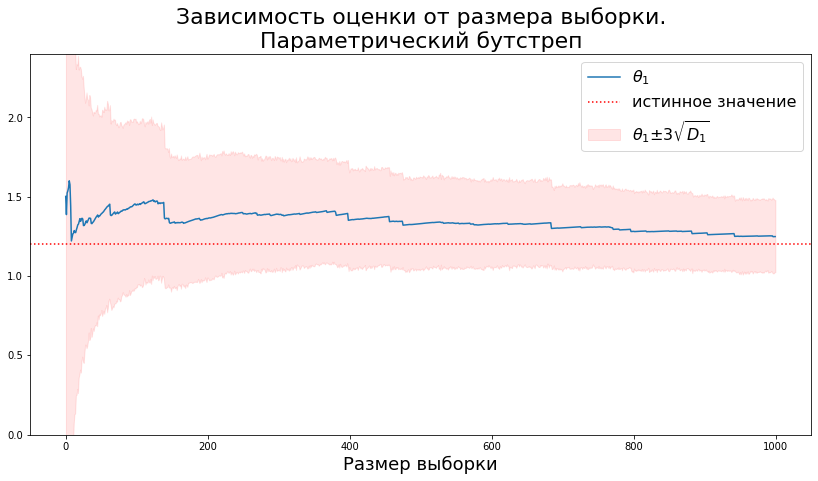

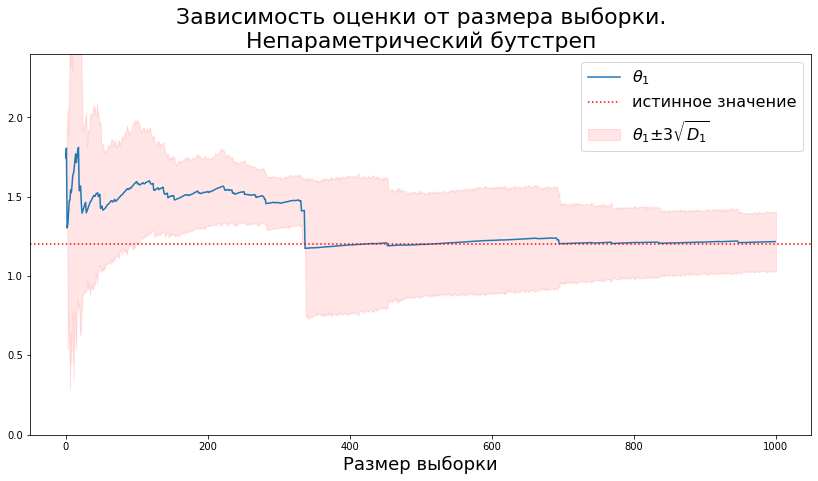

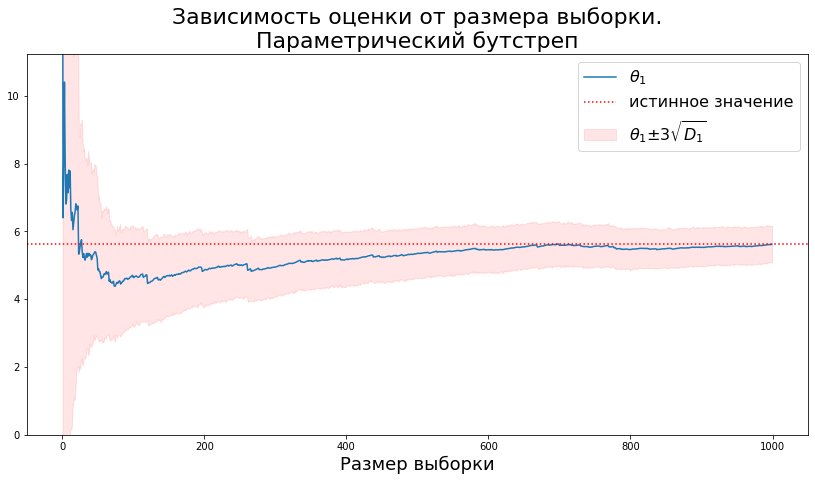

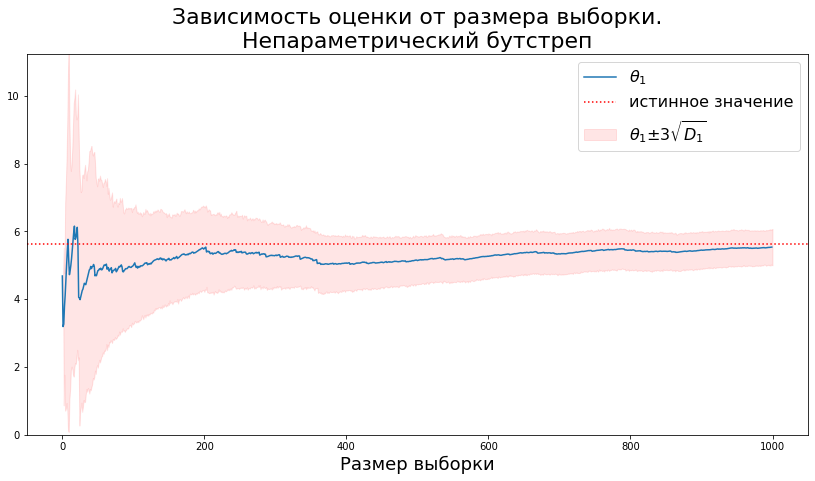

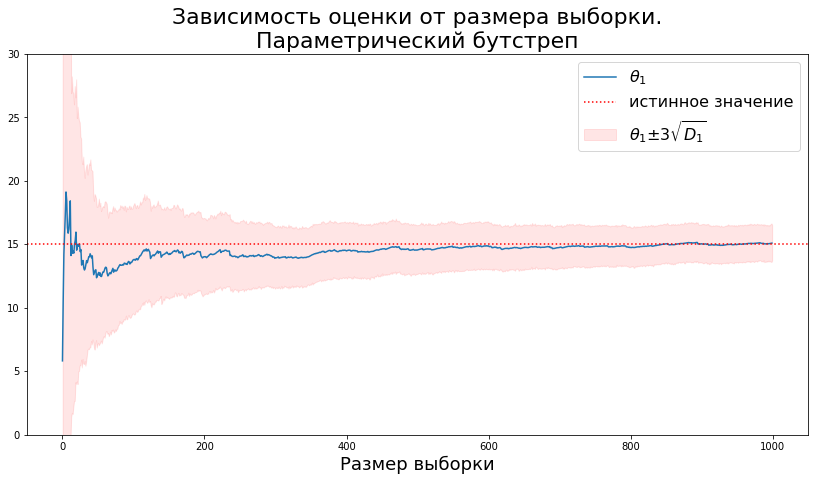

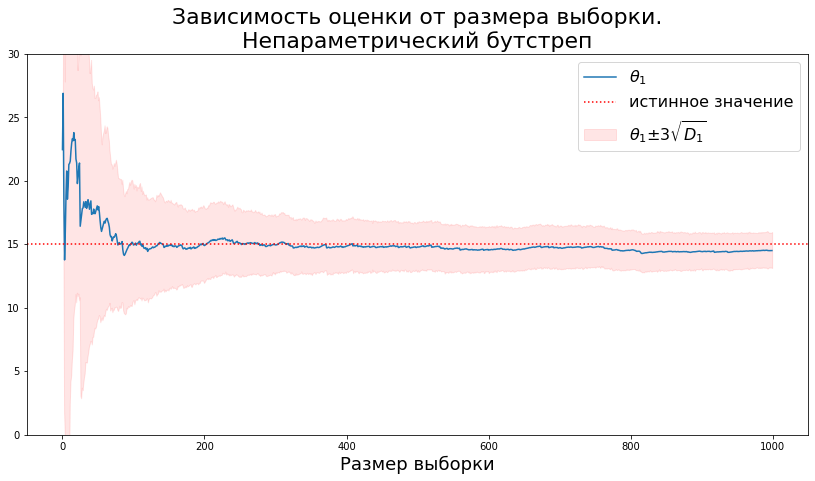

In [8]:
distribution = sps.pareto
all_start_params = [[1.2], [5.62], [15]]

estimators = [
    lambda x: np.mean(x, axis=-1) / (np.mean(x, axis=-1) - 1.)
]
param_to_sps = [
    lambda vec: vec[0],
]
sps_args = ['b']

for start_params in all_start_params:
    b = start_params[0]
    mod='parametric'
    all_estimations, all_variances = task_one(distribution, estimators,
                                              param_to_sps, mod, sps_args, 
                                              start_params)
    show_task_one(all_estimations, all_variances, 0,
                  (b-b, b+b), xline=b, mod=mod)
    mod='nonparametric'
    all_estimations, all_variances = task_one(distribution, estimators, 
                                              param_to_sps, mod, sps_args,
                                              start_params)
    show_task_one(all_estimations, all_variances, 0,
                  (b-b, b+b), xline=b, mod=mod)

$$ X_i \sim Cauchy(\theta) \Rightarrow \theta = \frac{1}{ tg\left(\pi P_n^{*}\left[0,1\right]\right) }$$

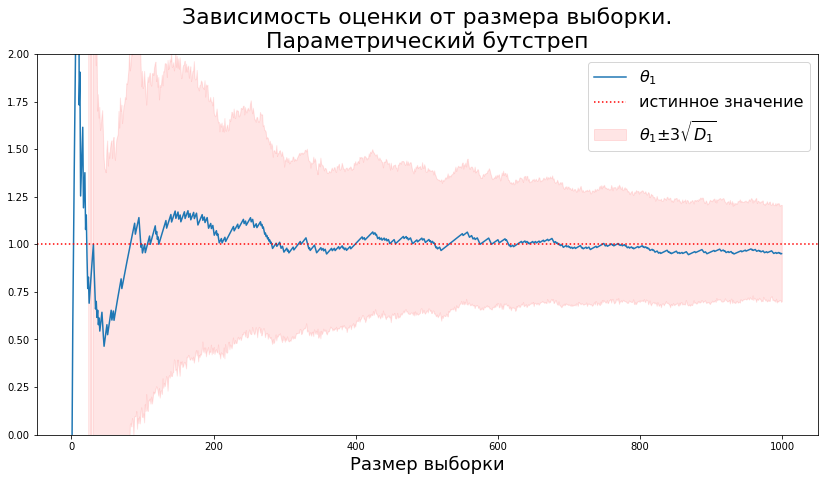

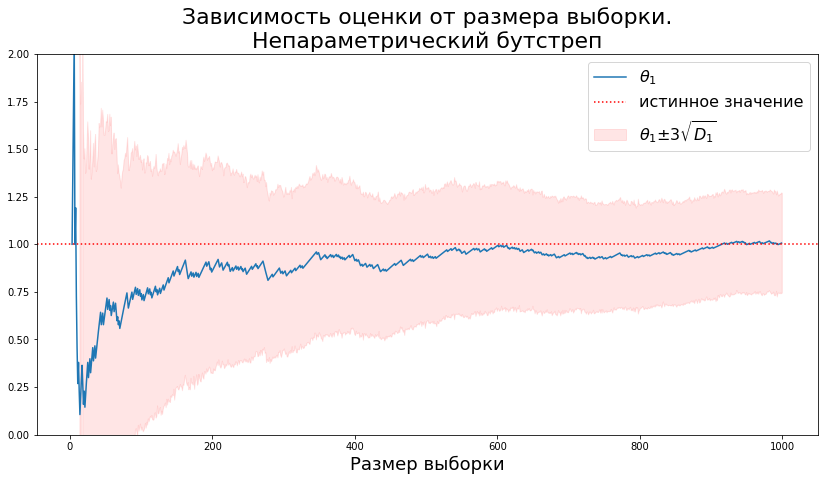

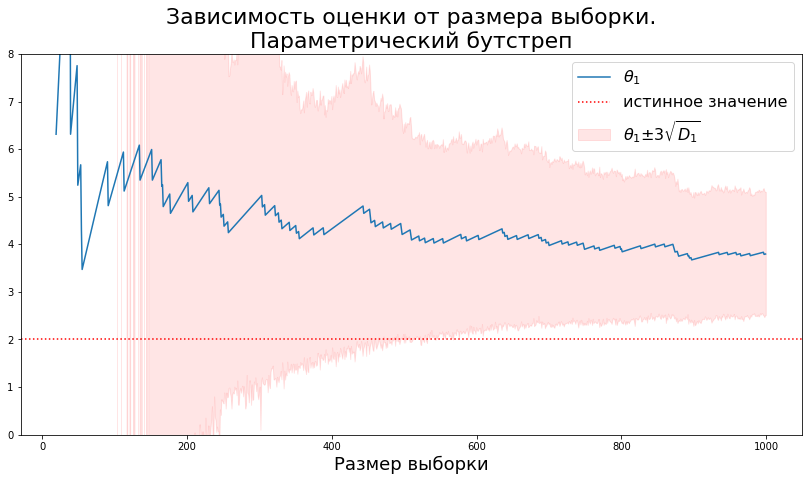

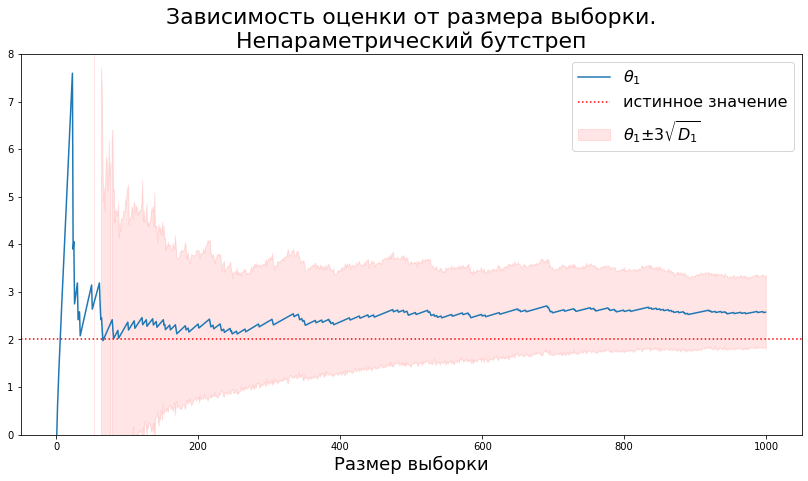

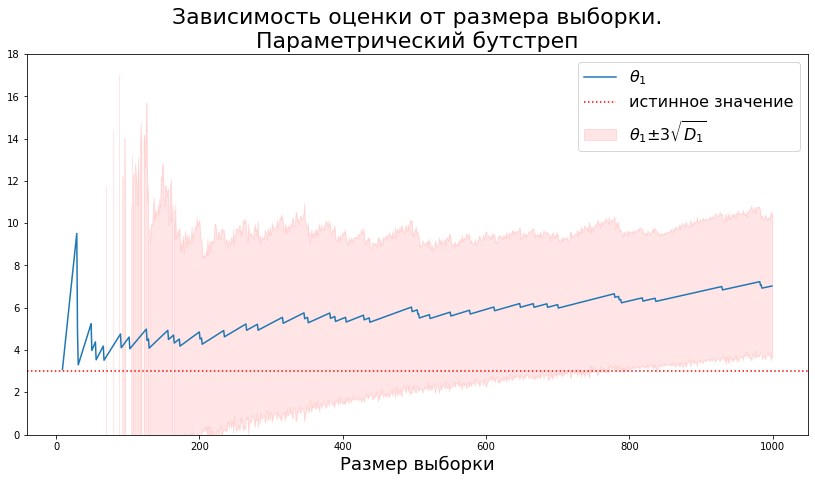

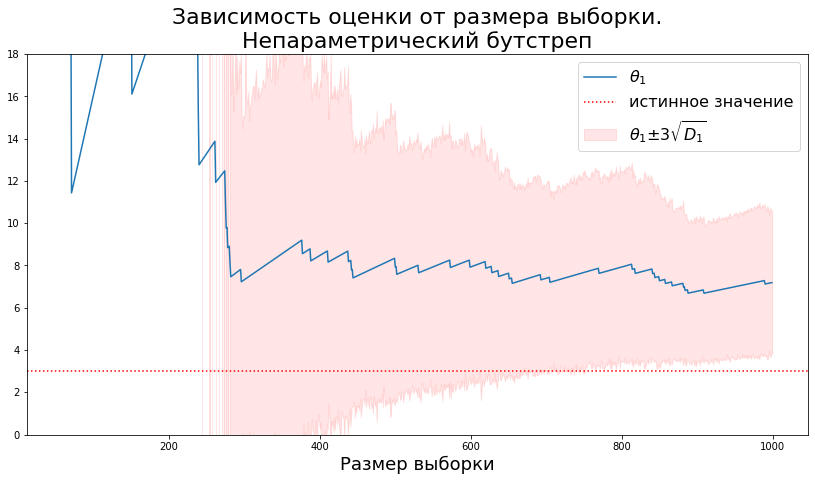

In [75]:
distribution = sps.cauchy
all_start_params = [[1], [2], [3]]

estimators = [
    lambda x:
        1. / 
        np.tan(
            np.pi * 
            np.sum(
                np.logical_and(x >=0, x <= 1),
                axis=-1
            ) 
            / x.shape[-1]
        )
]
param_to_sps = [
    lambda vec: vec[0]
]
sps_args = ['scale']

for start_params in all_start_params:
    scale = start_params[0]
    mod='parametric'
    all_estimations, all_variances = task_one(distribution, estimators,
                                              param_to_sps, mod, sps_args, s
                                              tart_params)
    show_task_one(all_estimations, all_variances, 0,
                  (0, 2*scale**2), xline=scale, mod=mod)
    mod='nonparametric'
    all_estimations, all_variances = task_one(distribution, estimators, 
                                              param_to_sps, mod, sps_args,
                                              start_params)
    show_task_one(all_estimations, all_variances, 0, 
                  (0, 2*scale**2), xline=scale, mod=mod)

### Вывод
В распределении Коши параметры, большие единицы приближаются нашей оценкой по методу моментов значительно хуже чем в других распределениях. Вероятно, это связано с тем, что у самого распределения Коши нет моментов, а для этой оценки мы используем специфические пробные функции

## Вывод
В большинстве случаев, при больших значениях параметра, его оценка может плохо приближать истинное значение, но, почти всегда, оно все равно попадает в интервал из правила "трех сигм"

# Задача 2
## Условие
На высоте 1 метр от поверхности Земли закреплено устройство,
которое периодиче\-ски излучает лучи на поверхность Земли (считайте,
что поверхность Земли представ\-ляет из себя прямую). Пусть $l$ --
перпендикуляр к поверхности Земли, опущенный из точки, в которой
закреплено устройство. Угол к прямой $l$ (под которым происходит
излучение) устройство выбирает случайно из равномерного
распределения на от\-резке $(-\pi/2, \pi/2)$ (все выборы
осуществляются независимо). В этих предположениях точки пересечения
с поверхностью имеют распределение Коши с плотностью $p(x) =
\frac{1}{\pi(1 + (x-x_0)^2}.$ Неизвестный параметр сдвига $x_0$
соответствует проекции точки расположения устройства на поверхность
Земли (направление оси и начало координат на поверхности Земли
выбраны заранее некоторым образом независимо от расположения
устройства). В файле Cauchy.csv находятся координаты точек
пересечения лучей с поверхностью Земли. Оцените параметр сдвига
методом максимального правдоподобия a) по поло\-вине выборки (первые
500 элементов выборки, т.е. выборка состоит из 1000 наблюде\-ний);
б) по всей выборке. Оценку произведите по сетке (т.е. возьмите набор
точек с некоторым шагом и верните ту, на которой достигается
максимум функции правдо\-подобия). Известно, что параметр масштаба
принадлежит интервалу $[-1000, 1000].$ Выберите шаг равным 0.01.
Если получается долго или не хватает памяти, то умень\-шите интервал
поиска и поясните (в комментариях), почему берете именно такой
интервал.

## Решение 
1. Считаем данные из csv файла
2. Посчитаем ф-цию правдоподобия в указанных точках
3. Найдем точку максимума

Функция правдоподобия имеет вид
$$\frac{1}{\pi^{n}} \frac{1}{\prod\left[1+\left(x_{i}-x_0\right)^{2}\right]}$$
Лог. ф-ция правдоподобия имеет вид 
$$-n \log \pi-\sum_{i=1}^{n} \log \left[1+\left(x_{i}-x_0\right)^{2}\right]$$

In [41]:
# возвращает лог. ф-цию правдоподобия
def get_log_likelihood_func(X):
    def log_likelihood_func(thetas):
        return -np.sum(np.log(1. + (X[None,:] - thetas[:,None])**2), axis=-1)
    return log_likelihood_func

# ищет точку максимума лог. ф-ции правд-ия
def grid_search_log_likelihood(X, left, right, delta, visualise=False):
    # получаем лог. ф-цию правдоподобия
    log_likelihood_func = get_log_likelihood_func(X)
    # получаем сетку - значения аргумента ф-ции
    grid = np.arange(left, right, delta)
    # вычисляем значения ф-ции в точках из нашей сетки
    log_likelihood_vals = log_likelihood_func(grid)
    # находим argmax ф-ции правдоподобия 
    argmax = np.argmax(log_likelihood_vals)
    
    if visualise:
        plt.figure(figsize=(14,7))
        plt.plot(grid, log_likelihood_vals, 
                 label='лог. функция правдоподобия')
        plt.axvline(grid[argmax], ls=':', c='red', label='ОМП')
        plt.xlabel('x', fontsize=18)
        plt.legend(fontsize=16)
        plt.show()
    
    # возващаем аргумент, при котором ф-ция правдоподобия достигает своего максимума
    return grid[argmax]

In [14]:
# считываем выборку из файла
X = pd.read_csv('Cauchy.csv', header=None).values.flatten()

In [15]:
# посчитаем ОМП по половине выборке
print(grid_search_log_likelihood(X[:500], -1000., 
                                 1000., 0.01))

662.0399999984884


In [16]:
# посчитаем ОМП по всей выборке
print(grid_search_log_likelihood(X, -1000., 1000., 0.01))

662.0499999984884


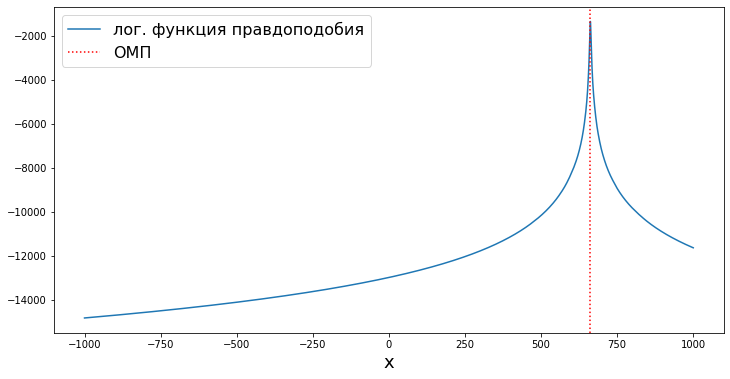

662.0499999984884

In [20]:
# нарисуем график ф-ции правдоподобия и отметим точку, 
# которую мы нашли (в которой должен достигаться максимум)
grid_search_log_likelihood(X, -1000., 1000., 0.01, True)

## Вывод 
Мы нашли значение параметра с помощью метода максимального правдоподобия. Значение параметра примерно равно 662.05
Действительно, на графике лог. ф-ции правдоподобия видно, что в этой точке достигается максимум

Теперь построим настоящую плотность распределения Коши с таким параметром и на том же графике плотность, оцененную по выборке 

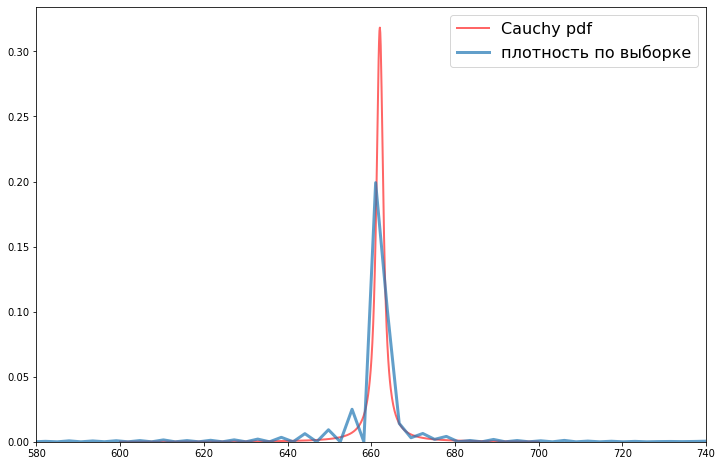

In [24]:
plt.figure(figsize=(12,8))
x = np.linspace(600, 700, 1000)
# строим график плотности распределения Коши с найденным только что параметром
plt.plot(x, sps.cauchy.pdf(x, loc=662.05), 'r-', lw=2, 
         alpha=0.6, label='Cauchy pdf')
# строим плотность, которая получена по выборке с помощью библиотеки seaborn
kdeplot(X, lw=3, alpha=0.7, label='плотность по выборке')
plt.xlim((620-40, 700+40))
plt.legend(fontsize=16)
plt.show()

## Вывод 
На графике видно, что плотность, полученная по выборке встроенной функцией, почти совпала с плотностью, полученной нашими вычислениями параметра с помощью метода максимального правдоподобия

# Задача 3
## Условие
В банке каждую минуту подсчитывается баланс по
сравнению с началом дня (6 часов утра). В полночь работники банка
измеряют две величины: $X^1$ -- максимальное значение баланса за
день, $X^2$ $-$ значение баланса в полночь. Считается, что величина
$X = X^1 - X^2$ имеет распределение Вейбулла с функцией распределения $F(x) = 1 - e^{-x^\gamma} (x > 0),$ где $\gamma > 0$ --
параметр формы. В течение 10 лет каж\-дый день банк проводил
измерение величины $X,$ получив в результате выборку $X_1, \ldots,
X_{3652}.$ В файле Weibull.csv находятся соответствующие измерения.
Оцените параметр формы методом максимального правдоподобия a) по
первым 4 годам; б) по всей выборке. Оценку произведите по сетке (в
логарифмической шкале). Известно, что $\log_{10}\gamma \in [-2, 2].$
Выберите шаг равным $10^{-3}.$

Решение аналогично предыдущей задаче

In [81]:
# возвращает лог. ф-цию правдоподобия
def get_log_likelihood_func(X):
    def log_likelihood_func(thetas):
        N = len(X)
        first = N * np.log(thetas)
        second = -np.sum(X[None,:] ** thetas[:,None], axis=-1)
        third = (thetas - 1.) * np.sum(np.log(X))
        return first + second + third
    return log_likelihood_func

# ищет точку максимума лог. ф-ции правд-ия
def grid_search_log_likelihood(X, left, right, delta,
                               visualise=False, xlim=None, ylim=None):
    # получаем лог. ф-цию правдоподобия
    log_likelihood_func = get_log_likelihood_func(X)
    # получаем сетку - значения аргумента ф-ции
    grid = 10 ** np.arange(left, right + delta, delta)
    # вычисляем значения ф-ции в точках из нашей сетки
    log_likelihood_vals = log_likelihood_func(grid)
    # находим argmax ф-ции правдоподобия 
    argmax = np.argmax(log_likelihood_vals)
    
    # рисуем график
    if visualise:
        plt.figure(figsize=(14,7))
        plt.plot(grid, log_likelihood_vals, 
                 label='лог. функция правдоподобия')
        plt.axvline(grid[argmax], ls=':', c='red', 
                    label='ОМП')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.legend(fontsize=14)
        plt.show()
    
    # возващаем аргумент, при котором ф-ция правдоподобия
    # достигает своего максимума
    return grid[argmax]

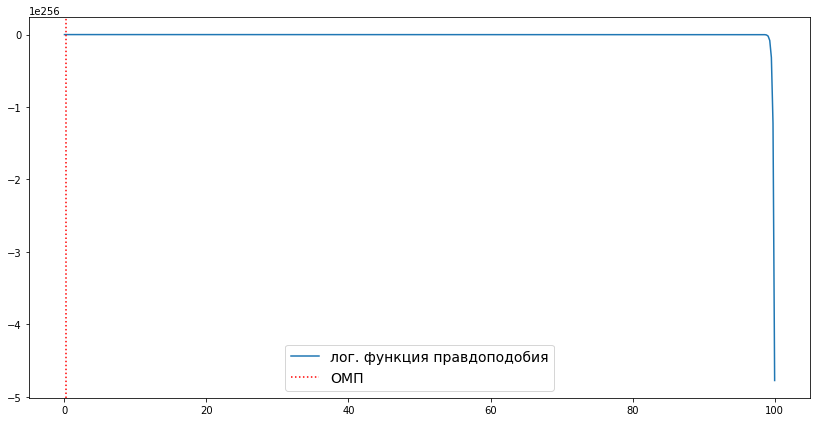

In [43]:
# читаем выборку из файла
X = pd.read_csv('Weibull.csv', header=None).values.flatten()
# устанавливаем параметры отображения вещественных чисел
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# заменяем нули в выборки на числа, очень близкие к нулю
X[X == 0.] = 10**-8

# находим ОМП и рисуем график лог ф-ции правдоподобия
param = grid_search_log_likelihood(X, -2, 2, 10**-3, True)

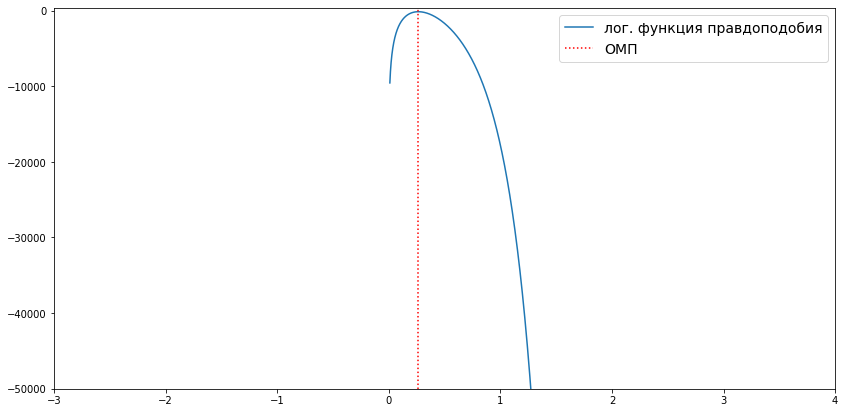

In [44]:
# рисуем тот же график, но уже в окрестности точки, где достигается максимум 
param = grid_search_log_likelihood(X, -2, 2, 10**-3, True, 
                                   (-3, 4), (-50000, 300))

In [47]:
print('ОМП по выборке за 4 года =', grid_search_log_likelihood(X[:365*4]
                                                               , -2, 2, 10**-3))
print('ОМП по выборке за 10 лет =', grid_search_log_likelihood(X, -2, 2,
                                                               10**-3))

ОМП по выборке за 4 года = 0.2703958364107862
ОМП по выборке за 10 лет = 0.2648500138605745


## Вывод
Мы нашли значение параметра формы. Оно примерно равно 0.2648. Действительно, на графике лог. ф-ции правдоподобия видно, что в этой точке достигается максимум.

Теперь, аналогично прошлой задаче, построим график плотности распределения Вейбулла с найденным только что параметром и на том же графике построим плотность, которая получена по выборке с помощью библиотеки seaborn

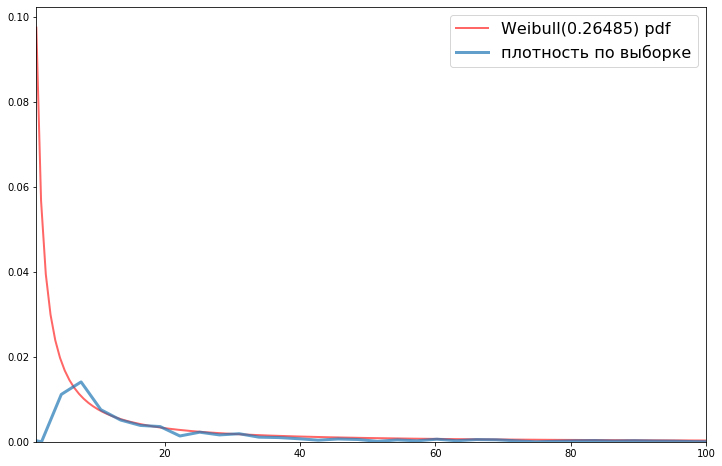

In [59]:
plt.figure(figsize=(12,8))
x = np.linspace(1, 700, 1000)
# строим график плотности распределения Коши с найденным только что параметром
plt.plot(x, sps.weibull_min.pdf(x, 0.26485), 'r-', lw=2, 
         alpha=0.6, label='Weibull(0.26485) pdf')
# строим плотность, которая получена по выборке с помощью библиотеки seaborn
kdeplot(X, lw=3, alpha=0.7, label='плотность по выборке')
plt.xlim((1, 100))
plt.legend(fontsize=16)
plt.show()

Построим тот же график, только "поближе"

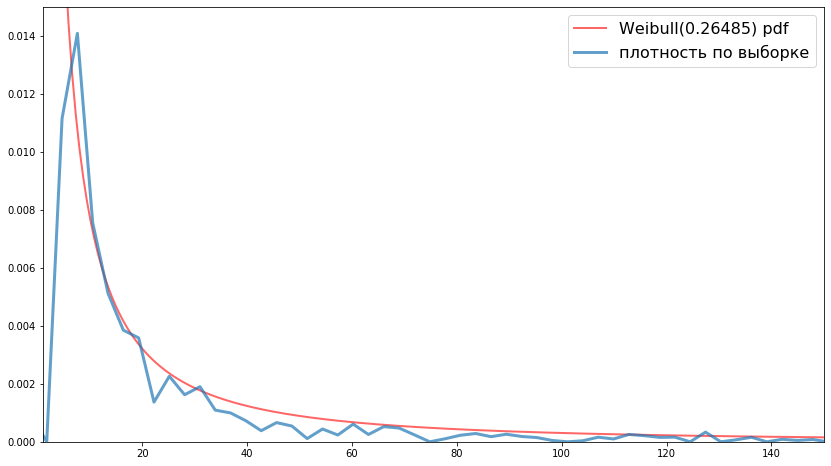

In [60]:
plt.figure(figsize=(14,8))
x = np.linspace(1, 700, 1000)
# строим график плотности распределения Вейбулла с найденным только что параметром
plt.plot(x, sps.weibull_min.pdf(x, 0.26485), 'r-', lw=2, 
         alpha=0.6, label='Weibull(0.26485) pdf')
# строим плотность, которая получена по выборке с помощью библиотеки seaborn
kdeplot(X, lw=3, alpha=0.7, label='плотность по выборке')
plt.xlim((1, 150))
plt.ylim((0, 0.0150))
plt.legend(fontsize=16)
plt.show()

## Вывод
На графике видно, что плотность, полученная по выборке встроенной функцией, почти совпала с плотностью, полученной нашими вычислениями параметра с помощью метода максимального правдоподобия